
<h1 class="text-center">Méthodes de Monte-Carlo</h1>

- [I. Calcul du volume d'une sphère par la méthode de Riemann](#RIEMANN)
- [II. Introduction à la méthode de Monte-Carlo : le cas IID](#MC)
- [III. Eléments de simulation stochastique et méthode du rejet](#SIMUSTO)
- [IV. Méthodes de réduction de variance](#IS)
- [V. Introduction aux chaînes de Markov](#INTROMARKOV)
- [VI. Méthodes de Monte-Carlo à base de chaînes de Markov](#MCMC)
- [VII. Chemins auto-évitants](#SAW)

<br>


In [1]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3

def grille_Riemann(dim, taille_echantillon):
    """
    renvoie les centres d'hypercubes d'une grille multidimensionnelle
    """
    N = int(taille_echantillon**(1.0/dim)) # nb de boites par cote, eventuellement arrondi
    delta=2.0/N
    allG = [np.linspace(-1+delta/2,1-delta/2,num=N) for G in range(dim)]
    mesh = np.meshgrid(*allG)
    ans = list(zip(*(d.flat for d in mesh)))
    
    if len(ans) != taille_echantillon:
        print '> Taille dechantillon ajustee pour la methode de Riemann:', len(ans),  'au lieu de', taille_echantillon,'(dimension =',dim,')'
    return np.array(ans)

def N_effectif(dim, taille_echantillon):
    """
    renvoie le nombre d'hypercubes utilisés lors de la discrétisation
    donne le même résultat que len(grille_Riemann(dim, taille_echantillon))
    mais sans générer la grille
    """
    return (int(taille_echantillon**(1.0/dim)))**dim

def estimation_Riemann(dim, grille):
    """
    calcule l'approximation du volume de la sphére en dimension
    dim à l'aide de sommes de Riemann sur la grille fournie
    """   
    N = len(grille)    
    estimation = ((2.0**dim) / N) * np.sum(np.linalg.norm(grille,2,axis=1) <= 1.0)    
    V_theorique = (np.pi**(dim / 2.0)) / special.gamma((dim / 2.0) + 1.0)    
    ecart_relatif = (estimation - V_theorique) / V_theorique
    return [estimation, ecart_relatif]

def estimation_Riemann_coin(dim, grille):
    """
    calcule l'approximation du volume de la sphére en dimension
    dim à l'aide de sommes de Riemann sur une grille obtenue avec un 
    déplacement de delta/2 de la grille fournie. Au lieu de travailer avec des centres
    des hypercubes, on travail avec des coins.
    """    
    N = len(grille) 
    delta = 2.0 / (N**(1.0 / dim))  
    grille = grille + (delta / 2.0)               
    estimation = ((2.0**dim) / N) * np.sum(np.linalg.norm(grille,2,axis=1) <= 1.0)
    V_theorique = (np.pi**(dim / 2.0)) / special.gamma((dim / 2.0) + 1.0)        
    ecart_relatif = (estimation - V_theorique) / V_theorique   
    return [estimation, ecart_relatif]

def estimationp(dim, taille_echantillon, t):
    
    grille = np.random.uniform(-1, 1, size=(taille_echantillon, dim))
    estimation = (1.0 / taille_echantillon) * np.sum(np.linalg.norm(grille,2,axis=1) < t)     
    return estimation 

def estimation_IIDMC(dim, taille_echantillon):
    """
    calcule l'approximation du volume de la sphére en dimension
    dim à l'aide de la méthode de Monte-Carlo
    """    
    grille = np.random.uniform(-1, 1, size=(taille_echantillon, dim))   
    V_theorique = (np.pi**(dim / 2.0)) / special.gamma((dim / 2.0) + 1.0) 
    estimation = ((2.0**dim) / taille_echantillon) * np.sum(np.linalg.norm(grille,2,axis=1) <= 1.0)       
    ecart_relatif = (estimation - V_theorique) / V_theorique
    erreur_relative = ((((2.0**dim) / V_theorique) - 1.0) / taille_echantillon)**(.5)      
    return [estimation, ecart_relatif, erreur_relative]



<br>

<br>

<a id="RIEMANN"></a><h1 style="border: 5px solid; text-align: center; padding: 10px"> I. Calcul du volume d'une sphère par la méthode de Riemann</h1>

<div class="alert alert-success" style="text-align: center;">On montre dans cette partie les limitations des techniques d'intégration en grande dimension. L'exemple de l'estimation du volume d'une sphère sera le fil rouge du cours.</div>

Le volume $V_d$ délimité par la sphère de rayon $1$ en dimension $d$ est donné par l'expression suivante:
$$ V_d = \frac{\pi^\frac{d}{2}}{\Gamma(d/2+1)} \mathop{\sim}_{d \to \infty} \frac{1}{\sqrt{\pi d}} \left( \frac{2e\pi}{d} \right)^{d/2}
$$

où $\Gamma$ correspond à la fonction Gamma. Réexprimant $V_d$ sous forme intégrale :
$$ V_d = \int_{[-1,1]^d} f(x) dx \ \text{ avec } \ f(x) = {\bf 1}(\lVert x \rVert \leq 1) $$
on souhaite retrouver la valeur de $V_d$ en estimant l'intégrale ci-dessus à l'aide de sommes de Riemann. Si l'on divise $[-1,1]^d$ en hypercubes de côté $\delta$, on obtient alors l'approximation
$$ \int_{[-1,1]^d} f \approx \widehat V^{\text{R}}_d \ \text{ avec } \ \widehat V^{\text{R}}_d = \sum_{k=1}^N \delta^d f(x_k) = \frac{2^d}{N} \sum_{k=1}^N f(x_k) $$
où les $x_k$ sont les centres des hypercubes et $N  = (2/\delta)^d$ est le nombre d'hypercubes. Puisque $f$ est continue par morceaux, on a bien $\widehat V^{\text{R}}_d \to V_d$ lorsque le nombre $N$ d'hypercubes utilisés tend vers $+\infty$, i.e., lorsque le pas $\delta$ de la discrétisation tend vers $0$.

<div class="alert alert-success">On définit **l'écart relatif** comme la différence entre l'estimateur et sa valeur théorique, normalisée par la valeur théorique :
$$ \text{écart relatif } = \frac{ \widehat V - V }{V} $$
Ici, on connaît la valeur théorique et on peut donc calculer cet écart relatif, mais en pratique la valeur théorique, et donc l'écart relatif, est inconnue.</div>

<p class="bg-primary" style="padding:1em">**QUESTION I.1.** Complétez la fonction `estimation_Riemann` dans le fichier `fonctions_estimation`, puis utilisez le script suivant pour tracer sur une même courbe $\widehat V^{\text{R}}_d$ et sa valeur théorique lorsque $d$ varie entre $2$ et $13$, puis tracez l'évolution de l'écart relatif. Commentez les résultats obtenus et notamment l'influence de $N$ et de la dimension $d$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION I.1.** 

Ce que j'ai pu constater c'est que pour une taille d'échantillon (N) fixe, à chaque fois que l'on augmente le nombre de dimensions (d), la méthode de Riemann devient de plus en plus moins précis e plus instable. Pour N supérieur et d fixe, la méthode nous permet de nous approcher les valeurs théoriques, mais le temps de calcul est beaucoup plus long. 

</div>

In [2]:
N = 10**6
dimensions = range(2,14)
nb_dimensions = len(dimensions)

In [3]:
from fonctions_auxiliaires import grille_Riemann, N_effectif
from fonctions_estimation import estimation_Riemann, estimation_Riemann_coin, estimation_IIDMC, estimationp

In [5]:
est_Riemann = np.zeros([nb_dimensions,2])
val_th = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    print '\n> Estimation par la methode de Riemann en dimension', dim, ': '
    grille = grille_Riemann(dim, N)
    est_Riemann[i,:] = estimation_Riemann(dim, grille)
    print '> [Estimation, Écart Relatif] = ', est_Riemann[i,:]
    val_th[i] = (np.pi**(dim / 2.0))/special.gamma(dim / 2.0 + 1)


> Estimation par la methode de Riemann en dimension 2 : 
> [Estimation, Écart Relatif] =  [  3.14182400e+00   7.36398495e-05]

> Estimation par la methode de Riemann en dimension 3 : 
> Taille dechantillon ajustee pour la methode de Riemann: 970299 au lieu de 1000000 (dimension = 3 )
> [Estimation, Écart Relatif] =  [  4.19145851e+00   6.37010751e-04]

> Estimation par la methode de Riemann en dimension 4 : 
> Taille dechantillon ajustee pour la methode de Riemann: 923521 au lieu de 1000000 (dimension = 4 )
> [Estimation, Écart Relatif] =  [  4.93098912e+00  -7.72692347e-04]

> Estimation par la methode de Riemann en dimension 5 : 
> Taille dechantillon ajustee pour la methode de Riemann: 759375 au lieu de 1000000 (dimension = 5 )
> [Estimation, Écart Relatif] =  [ 5.34195095  0.01484899]

> Estimation par la methode de Riemann en dimension 6 : 
> Taille dechantillon ajustee pour la methode de Riemann: 531441 au lieu de 1000000 (dimension = 6 )
> [Estimation, Écart Relatif] =  [ 5.468

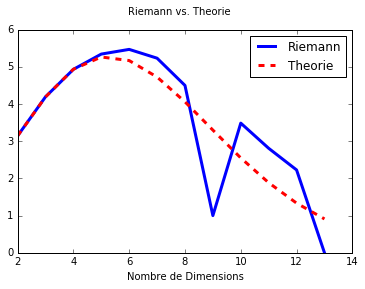

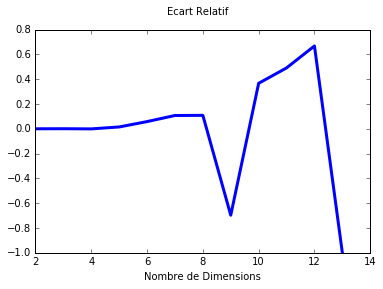

In [6]:
fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, val_th, 'r--', label="Theorie")
plt.legend(["Riemann", "Theorie"])
fig.suptitle("Riemann vs. Theorie")
plt.xlabel("Nombre de Dimensions")

fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,1])
fig.suptitle("Ecart Relatif")
plt.xlabel("Nombre de Dimensions")


<p class="bg-primary" style="padding:1em">**QUESTION I.2.** Que calcule le code suivant ? Commentez la courbe obtenue.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION I.2.** 
Le code suivante nous donne une idée de la vitesse à laquelle l'estimation de Riemann s'approche de la valeur théorique, i.e., $-log(|(V_{estimee} - V_{theorique}|)$.

Comme pour dimensions différentes le nombre d'hypercubes utilisés varie (au lieu de N, nous avons $N_{effectif}$), il a fallu diviser par $log(N_{effectif})$ pour eliminer cette dépendance.

La vitesse de convergence commence à 0.6 pour $dim = 2$ et sa valeur chute à chaque fois que dim augmente (sauf de $dim = 9$ jusqu'à $dim = 10$). Notre estimation avec la méthode de Riemann devient donc pire, pour les dimensions de plus en plus hautes. En effet, dès que l'on a $dim > 10$, $-log(|(V_{estimee} - V_{theorique}|) \approx 0$, ce que signifie que la valeur estimée est vraiment loin de la théorique.
   
</div>

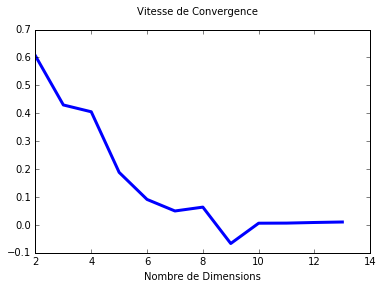

In [7]:
vitesse_R = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    vitesse_R[i] = -np.log(np.absolute(est_Riemann[i,0] - val_th[i])) / np.log(N_effectif(dim, N))
plt.plot(dimensions, vitesse_R)
plt.xlabel("Nombre de Dimensions")
plt.suptitle("Vitesse de Convergence")

On s'intéresse à la robustesse de l'estimation précédente. Pour cela, on considère
$$ \widehat V^{\text{Rc}}_d = \frac{2^d}{N} \sum_{k=1}^N f(c_k) $$
où $c_k$ est le coin de l'hypercube $k$, i.e., $c_k = x_k + \frac{\delta}{2} {\bf 1}$ avec ${\bf 1} = (1, \ldots, 1) \in R^n$.

<p class="bg-primary" style="padding:1em">**QUESTION I.3.** Définissez la fonction `estimation_Riemann_coin` (toujours dans le fichier `fonctions_estimation`) afin qu'elle renvoie l'estimation et l'écart correspondant à cette nouvelle approximation. Rajoutez sur les courbes précédentes les résultats liés à cette estimation et commentez les résultats obtenus.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION I.3.** 
On trouve pas une amélioration des résultats avec Riemann coin. En effet, la seule chose qui l'on a changé était décaller les points dans la grille. Mais ils restent toujours y placés de façon homogène.
</div>

In [8]:
est_Riemann = np.zeros([nb_dimensions,2])
est_Riemann_coin = np.zeros([nb_dimensions,2])
for i in range(nb_dimensions):
    dim = dimensions[i]
    grille = grille_Riemann(dim, N)
    print '\n> Estimation par la methode de Riemann (coin) en dimension ' ,dim
    est_Riemann[i,:] = estimation_Riemann(dim, grille)
    est_Riemann_coin[i,:] = estimation_Riemann_coin(dim, grille)
    print '> [Estimation (coin), Écart Relatif] = ', est_Riemann_coin[i,:]


> Estimation par la methode de Riemann (coin) en dimension  2
> [Estimation (coin), Écart Relatif] =  [  3.14138800e+00  -6.51432609e-05]
> Taille dechantillon ajustee pour la methode de Riemann: 970299 au lieu de 1000000 (dimension = 3 )

> Estimation par la methode de Riemann (coin) en dimension  3
> [Estimation (coin), Écart Relatif] =  [  4.18325485e+00  -1.32146805e-03]
> Taille dechantillon ajustee pour la methode de Riemann: 923521 au lieu de 1000000 (dimension = 4 )

> Estimation par la methode de Riemann (coin) en dimension  4
> [Estimation (coin), Écart Relatif] =  [  4.91808199e+00  -3.38822249e-03]
> Taille dechantillon ajustee pour la methode de Riemann: 759375 au lieu de 1000000 (dimension = 5 )

> Estimation par la methode de Riemann (coin) en dimension  5
> [Estimation (coin), Écart Relatif] =  [ 5.23613761 -0.00525314]
> Taille dechantillon ajustee pour la methode de Riemann: 531441 au lieu de 1000000 (dimension = 6 )

> Estimation par la methode de Riemann (coin) en 

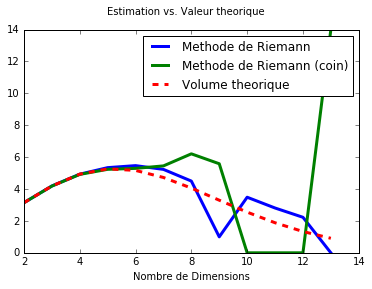

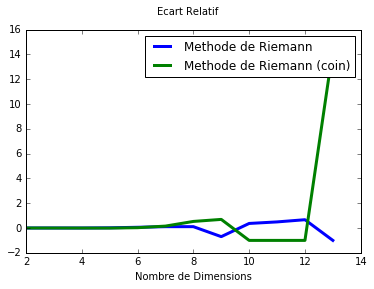

In [9]:
fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,0], label="Methode de Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Methode de Riemann (coin)")
plt.plot(dimensions, val_th, 'r--', label="Volume theorique")
plt.legend()
plt.xlabel("Nombre de Dimensions")
fig.suptitle("Estimation vs. Valeur theorique")

fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,1], label="Methode de Riemann")
plt.plot(dimensions, est_Riemann_coin[:,1], label="Methode de Riemann (coin)")
plt.legend()
plt.xlabel("Nombre de Dimensions")
fig.suptitle("Ecart Relatif")

<p class="bg-primary" style="padding:1em">**QUESTION I.4.** Soit $V^-_d$ le volume de la sphère de rayon $1 - K/d$ en dimension $d$ : montrez théoriquement que $V_d - V^-_d \sim (1-e^{-K}) V_d$ lorsque $d \to \infty$, et utilisez ce résultat pour interpréter les résultats précédents.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION I.4.** 
Le volume de la sphère de rayon R = 1-K/d est donné par le volume de la sphère unitaire multiplié par le rayon puissance d. Donc:

$$V_d = \frac{\pi^\frac{d}{2}}{\Gamma(d/2-1)}$$
$$ $$
$$V_d^{-} = V_dR^{d} = V_d\bigg(1-\frac{K}{d}\bigg)^{d}$$

La différence entre eux est donnée par:

$$V_{d} - V_{d}^{-} = V_{d} - V_d\bigg(1-\frac{K}{d}\bigg)^{d} = V_d\bigg[1-\bigg(1-\frac{K}{d}\bigg)^{d}\bigg]$$

Le limite lorsque $d \rightarrow +\infty$ est calculé comme ci-dessous:
$$ $$
$$ \lim_{d\to\infty} V_d\bigg[1-\bigg(1-\frac{K}{d}\bigg)^{d}\bigg] = \lim_{d\to\infty} V_d \times \bigg[1 - \lim_{d\to\infty}\bigg(1-\frac{K}{D}\bigg)^d\bigg] = \lim_{d\to\infty} V_d \times \bigg[1 - \lim_{d\to\infty}\bigg(\bigg(1+\frac{1}{-d/K}\bigg)^{-d/K}\bigg)^{-K}\bigg] $$
$$ $$
$$ = \lim_{d\to\infty} V_d (1 - e^{-K}) = V_d (1 - e^{-K})$$

Q.E.D.
$$ $$
Pour l'interprétation: en faisant augmenter le rayon de la deuxième sphère (R = 1-K/d) vers l'infini, il va converger vers 1. Toutefois son volume ne converge pas vers le volume de la sphère de rayon 1. En effet, à l'infini:

$$V_{d}^{-} = V_d\big(1 - (1-e^{-K})\big) = e^{-K} V_d $$

c'est-à-dire, pour d suffisament grande, la deuxième sphère aura un volume égal à $e^{-K}$ fois du volume de la sphère de rayon 1. Les sphères auront donc des rayons égales et des volumes toutefois différents. Une fois que K peut prendre n'import quelle valeur, $V_{d}^{-}$ peut être infiniment petit. Le conclusion est donc que le volume d'une hypersphère en dimension $d \rightarrow \infty$ doit être concentré dans sa surface. Le volume d'une sphère dans un nombre infini de dimensions est zero. Si on reprend le fait que la méthode des sommes de Riemann utilise une grille avec des points disposés de façon homogène, elle ne prend pas en compte cette distribuition de volume, ce qu'explique les erreurs trouvés pour un grand nombre de dimensions.
</div>




<p class="bg-primary" style="padding:1em"> **$\star$ QUESTION I.5 $\star$.** Quel bilan tirez-vous de l'estimation d'intégrales par somme de Riemann? </p>

<div class="alert alert-warning">**REPONSE A LA QUESTION I.5.** 
Pour conclure, si l'on travail avec un nombre petit de dimensions, la méthode de Riemann nous permet d'arriver au résultat. L'estimation sera meilleure pour des échantillons plus grands, mais cela nous êmpechera de faire des calcules rapides. En outre, si l'on considère un grand nombre de dimensions (avec N fixe), la méthod échouera. Ce qui se passe c'est qu'en grandes dimensions le nombre de points (hypercubes) necessaires pour le calcule est aussi plus grand. En plus, la somme de Riemann utilise toujours des points disposés géometriquement dans une grille, et cela n'est pas la meilleure façon d'estimer l'integrale. Dans le cas précedent de la sphère, par exemple, nous avons vu que lorsque $d \rightarrow +\infty$, la sphère de rayon 1 avait sont volume concentré dans sa surface. Donc ce serait mieux d'y placer plus de points. Il se passe la même chose avec n'importe quelle fonction. Dans les régions où l'integrale est plus grande, il faudra y ajouter plus de points. La faiblesse de la méthode de Riemann s'agit donc du placement des points dans une grille.


</div>

<br>

<br>

<br>

<br>




<a id="MC"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">II. Introduction à la méthode de Monte-Carlo : le cas IID</h1>

<div class="alert alert-success" style="text-align: center;">On introduit maintenant la méthode de Monte-Carlo sur le même problème d'estimation du volume de la sphére et on discute sa vitesse de convergence.</div>

<div class="alert alert-success">**Rappel**. i.i.d. = indépendantes et identiquement distribuées</div>

<h2>II.1. Méthode de Monte-Carlo</h2>

Soit $(X_k, k \geq 1)$ des variables i.i.d. uniformément réparties sur $[-1,1]^d$ et
$$ \widehat V^{\text{MC}}_d = \frac{2^d}{N} \sum_{k=1}^N f(X_k). $$

<p class="bg-primary" style="padding:1em">**QUESTION II.1.1.** Donnez la densité de $X_1$ et justifiez que $\widehat V^{\text{MC}}_d \to V_d$ lorsque $N \to \infty$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.1.1.** 
Soit $g_X(x)$ la fonction densité de probabilité des variables aleatoires i.i.d $X_k$:
$$ $$
$$g_{X_K}(x) = \frac{1}{2^d}\mathbb{1}_{[-1,1]^d}$$

$$ $$


$$V_d = \int \mathbb{1}(\lvert X \rvert \leq 1) dx = \int \frac{\mathbb{1}(\lVert X \rVert \leq 1)}{2^d} 2^d dx = E[\mathbb{1}(\lVert X \rVert \leq 1)\times2^d]$$

$$ $$

Un estimator de $V_d$ peut être donc donné par:

$$ \frac{1}{N} \sum_{k=1}^N \mathbb{1}(\lVert X_k \rVert \leq 1)\times2^d = \frac{2^d}{N} \sum_{k=1}^N f(X_k) = \widehat V^{\text{MC}}_d $$

Avec $f(X_k) = \mathbb{1}(\lVert X_k \rVert \leq 1)$. Selon la loi des grands nombres on arrive finalement à:
$$ $$ 

$$ \lim_{N\to\infty} \widehat V^{\text{MC}}_d = V_d$$
</div>



<p class="bg-primary" style="padding:1em">**QUESTION II.1.2.** Complétez la fonction `estimation_IIDMC` afin d'ajouter aux courbes précédentes l'évolution de $\widehat V^{\text{MC}}_d$ ainsi que l'écart relatif correspondant. Commentez les courbes obtenues.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.1.2.** 
Comme l'on peut constater, les valeurs estimées en utilisant l'estimator naïf de Monte-Carlo ne sont pas autant eloignées des valeurs théoriques comme ceux estimées avec les sommes de Riemann (pour la même taille d'échantillon). En effet, l'écart relative plus grand atteint était de 10.4% par rapport à la valeur théorique (à 11 dimensions). Pour comparer, les sommes de Riemann restaient proches de la valeur théorique jusqu'à $d=6$. On peut supposer que si au lieu d'utiliser la taille de l'échantillon effectif, on avait utilisé la vraie taille, les valeurs avec Monte-Carlo seraient encore meilleures.

</div>

In [10]:
from fonctions_estimation import estimation_IIDMC

In [11]:
est_IIDMC = np.zeros([nb_dimensions,3])
for i in range(nb_dimensions):
    dim = dimensions[i]
    print '\n> Estimation par Monte Carlo en dimension:', dim
    # pour une comparaison juste, on prend la même taille d'échantillon que pour Riemann
    est_IIDMC[i,:] = estimation_IIDMC(dim, N_effectif(dim, N))
    print '> [Estimation, Écart Relatif] = [', est_IIDMC[i,0], ",", est_IIDMC[i,1], "]"


> Estimation par Monte Carlo en dimension: 2
> [Estimation, Écart Relatif] = [ 3.141876 , 9.01919635835e-05 ]

> Estimation par Monte Carlo en dimension: 3
> [Estimation, Écart Relatif] = [ 4.18669296784 , -0.000500678440817 ]

> Estimation par Monte Carlo en dimension: 4
> [Estimation, Écart Relatif] = [ 4.93734739113 , 0.000515763444573 ]

> Estimation par Monte Carlo en dimension: 5
> [Estimation, Écart Relatif] = [ 5.25345711934 , -0.00196282460134 ]

> Estimation par Monte Carlo en dimension: 6
> [Estimation, Écart Relatif] = [ 5.19005496377 , 0.00432341824503 ]

> Estimation par Monte Carlo en dimension: 7
> [Estimation, Écart Relatif] = [ 4.71205025117 , -0.00269129079417 ]

> Estimation par Monte Carlo en dimension: 8
> [Estimation, Écart Relatif] = [ 4.0599552 , 0.000306272912322 ]

> Estimation par Monte Carlo en dimension: 9
> [Estimation, Écart Relatif] = [ 3.3671875 , 0.0208211041068 ]

> Estimation par Monte Carlo en dimension: 10
> [Estimation, Écart Relatif] = [ 2.7052

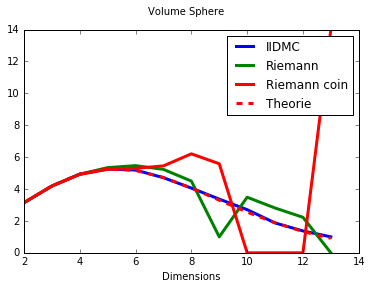

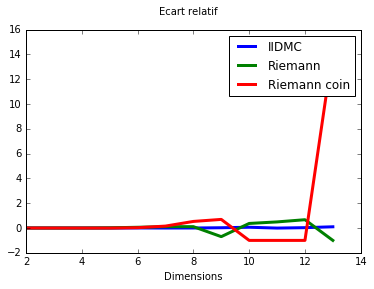

In [12]:
fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,0], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann coin")
th, = plt.plot(dimensions, val_th, 'r--', label="Theorie")
plt.legend()
plt.xlabel("Dimensions")
fig.suptitle("Volume Sphere")

fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,1], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,1], label="Riemann coin")
plt.legend()
plt.xlabel("Dimensions")
fig.suptitle("Ecart relatif")

<p class="bg-primary" style="padding:1em">**QUESTION II.1.3.** Faites tourner le script suivant et commentez les résultats obtenus.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.1.3.** 
Les courbes representées à vert et bleu correspondent à la vitesse de convergence de la méthode des sommes de Riemann et celle de Monte-Carlo.
On constante que tandis que la vitesse de convergence des sommes de Riemann diminue jusqu'à  approximativement zero avant $d=10$, la méthode IIDMC à une vitesse non nulle, même pour $d>10$. C'est-à-dire, les estimations selon Riemann s'eloignent de la valeur théorique, tandis que celles selon IIDMC ont un petit érreur en comparaison. Cependant les oscillations, même pour IIDMC la vitesse à une tendence à décroître avec le nombre de dimensions.
</div>

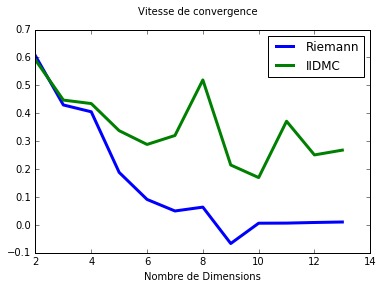

In [13]:
vitesse_IIDMC = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    vitesse_IIDMC[i] = -np.log(np.absolute(est_IIDMC[i,0] - val_th[i])) / np.log(N_effectif(dim, N))
fig = plt.figure()
plt.plot(dimensions, vitesse_R, label="Riemann")
plt.plot(dimensions, vitesse_IIDMC, label="IIDMC")
plt.legend()
plt.xlabel("Nombre de Dimensions")
fig.suptitle("Vitesse de convergence")

<p class="bg-primary" style="padding:1em">**QUESTION II.1.4.** Quelle est la vitesse de convergence théorique de l'estimateur $\widehat V^{MC}_d$? Cette vitesse dépend-elle de la dimension ? Commentez par rapport aux résultats numériques précédents.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.1.4.** 

Une fois que l'estimateur de Monte-Carlo est basé sur le théorème central limite, en faisant les définitions suivantes, on a:
$$ $$

$$ V_d = 2^dE[\mathbb{1}(\lVert X\rVert \leq 1)]$$  
$$\sigma^2 = 2^{2d}Var[\mathbb{1}(\lVert X \rVert \leq 1)]$$

$$ $$
$$ \frac{\frac{2^d\mathbb{1}(\lVert X_1 \rVert \leq 1) \space + ... + \space 2^d\mathbb{1}(\lVert X_N \rVert \leq 1)}{N}- V_d}{\sigma/\sqrt{N}} \sim N(0,1)$$

lorsque $N \rightarrow \infty$. Donc:
$$ \frac{2^d\mathbb{1}(\lVert X_1 \rVert \leq 1) \space + ... + \space 2^d\mathbb{1}(\lVert X_N \rVert \leq 1)}{N} - V_d = \widehat V^{\text{MC}}_d - V_d \sim N\bigg(0,\bigg(\frac{\sigma}{\sqrt{N}}\bigg)^2\bigg)$$

La vitesse théorique de la méthode de Monte Carlo est par conséquence donnée par $\sqrt{N}$. En faisant augmenter la taille de l'echantillon, la vitesse de convergence augmente. Toutefois, si l'on fait augmenter le nombre de dimensions, la variance $\sigma^2 = 2^{2d}Var[\mathbb{1}(\lVert X \rVert \leq 1)]$, elle augmente aussi, et par conséquence, la vitesse de convergence diminue. Les résultats numériques montrent une diminuition de la vitesse de convergence avec beaucoup d'oscillations. Toutefois les calculs pour Monte-Carlo ont été fait avec des tailles d'échantillon variables pour garder la même taille pour Riemann et IIDMC, donc cela peut expliquer les oscillations que l'on peut regarder dans le graphique.

</div>



<p class="bg-primary" style="padding:1em">**QUESTION II.1.5.** On fixe la dimension $d = 15$. Répétez l'expérience plusieurs fois : l'estimation donnée par $\widehat V^{\text{MC}}_d$ est-elle stable ? et la vitesse de convergence ? Commentez les résultats obtenus et notamment l'influence de $N$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.1.5.** 
Tout d'abord, pour correctement étudier l'influence de la taille de l'echantillon, dans le calculs j'ai utilisé N et pas le N effectif que j'avais utilisé précédemment pour comparer avec les sommes de Riemann. Pour 15 dimensions et en faisant varier la taille de l'echantillon, on constante que l'estimation IIMC s'approche de la valeur théorique pour N croissant comme prévu théoriquement. J'ai fait des calculs pour un N maximal de $10^6$. Au delà de cette valeur, l'estimation prend beaucoup longtemps. À chaque fois que l'on repete le calcul, on obtient des valeurs différentes, ce qu'était pŕevu une fois que l'estimator est il-même une variable aleatoire. Toutefois l'estimation est stable et bornée. La vitesse de convergence est aussi stable, étant toujours bornée pendant les 100 répétitions. Elle augmente lorsque l'on augmente la taille de l'echantillon, comme prevue théoriquement. Les valeurs estimées trouvées oscillent autour de la valeur théorique. Ces oscillations ont une amplitude qui decroître pour N croissant.
</div>

In [14]:
nb_repet = 10**2
N = 10**6
dim = 15
estim = np.zeros(nb_repet)
vitesse = np.zeros(nb_repet)
val_th = np.zeros(nb_repet) + np.pi**(dim / 2.0) / special.gamma(dim/2.0 + 1.0)
for i in range(nb_repet):
    estim[i] = estimation_IIDMC(dim, N)[0]
    vitesse[i] = -np.log(np.absolute(estim[i] - val_th[i])) / np.log(N)
print 'Ready!'

Ready!


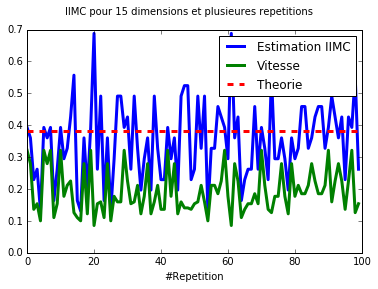

In [15]:
plt.plot(range(nb_repet), estim, label = "Estimation IIMC")
plt.plot(range(nb_repet), vitesse, label = "Vitesse")
plt.plot(range(nb_repet), val_th, 'r--', label = "Theorie")
plt.xlabel("#Repetition")
plt.legend()
plt.suptitle("IIMC pour 15 dimensions et plusieures repetitions")

<h2>II.2. Précision d'un estimateur</h2>

Le but de cette partie est de montrer que la variance n'est toujours pas une mesure satisfaisante pour mesurer la précision d'un estimateur. On considère pour cela la fonction $p(t) = P(\lVert X \rVert \leq t)$ où $X$ est uniformément répartie sur $[-1,1]^d$.


<p class="bg-primary" style="padding:1em">**QUESTION II.2.1** Donnez l'estimateur de Monte-Carlo de $p(t)$, que l'on notera $\widehat p(t)$, ainsi que son espérance et sa variance. En déduire que $\frac{1}{N} (\widehat p(t) - \widehat p(t)^2)$ est un estimateur de la variance de $\widehat p(t)$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.2.1.** 
La probabilité que l'on souhaite calculer est donnée par:

$$ $$
$$ p(t) = P(\lVert X \rVert  \leq t) = \int_{\lVert X \rVert  \leq t} f_X(x)dx = \int_{[-1,1]^d}\mathbb{1}(\lVert x\rVert \leq t)\frac{1}{2^d}dx=E[\mathbb{1}(\lVert X\rVert \leq t)] $$
$$ $$
Où $X \sim U[-1,1]^d$. Donc, un estimateur pour la calculer (celui de Monte-Carlo) est:
$$ $$
$$\widehat{p(t)}^{MC} = \frac{1}{N}\sum_{k=1}^N\mathbb{1}(\lVert X_k \rVert \leq t)$$
où $X_k$ sont $i.i.d$ et avec une densité donnée par $1/2^d$. Son esperance est calculé ci-dessous:
$$ $$
$$E[\widehat{p(t)}^{MC}] = \frac{1}{N}E\bigg[\sum_{k=1}^N\mathbb{1}(\lVert X_k \rVert \leq t)\bigg]$$
$$ $$
$$= \frac{1}{N}\sum_{k=1}^N E\bigg[\mathbb{1}(\lVert X_k \rVert \leq t)\bigg] = \frac{N}{N} E\big[\mathbb{1}(\lVert X \rVert \leq t)\big] = P(\lVert X \rVert  \leq t) = p(t)$$
$$ $$
L'estimateur est donc centré. Pour la variance, on a:
$$ $$
$$Var[\widehat{p(t)}^{MC}] = \frac{1}{N^2}Var\bigg[\sum_{k=1}^N\mathbb{1}(\lVert X_k \rVert \leq t)\bigg] = 
\frac{1}{N^2}\sum_{k=1}^N Var\bigg[\mathbb{1}(\lVert X_k \rVert \leq t)\bigg]$$
$$ $$
$$=\frac{1}{N^2}\sum_{k=1}^N\bigg(E[\mathbb{1}(\lVert X_k \rVert \leq t)^2]-E[\mathbb{1}(\lVert X_k \rVert \leq t)]^2\bigg)$$
$$ $$
$$=\frac{1}{N^2}\sum_{k=1}^N\bigg(E[\mathbb{1}(\lVert X_k \rVert \leq t)]-E[\mathbb{1}(\lVert X_k \rVert \leq t)]^2\bigg) = \frac{1}{N^2}\times N (p(t)-p(t)^2) = \frac{p(t)-p(t)^2}{N}$$
$$ $$
Donc son estimateur est:
$$ $$
$$\frac{\widehat p(t)- \widehat p(t)^2}{N}$$

</div>



<p class="bg-primary" style="padding:1em">**QUESTION II.2.2.** Complétez le script suivant afin de tracer $t \mapsto \widehat p(t) - \widehat p(t)^2$. Pour quelle valeur de $t$ l'estimateur vous semble-t-il être le moins précis ?</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.2.2.** 
Selon le graphique on peut être emmené a penser que pour la valeur maximale de la variance estimée l'estimateur est moin précis, i.e. pour $t$ tel que la courbe de la variance à bleu atteint son maximum (approximativement $t=2.25$). Toutefois, on a pas pris en compte le fait que lorsque les valeurs estimés sont petites, la variance est aussi inférieure. Par conséquence, l'estimation de la variance seule n'est pas un bon critère pour déterminer la précision de l'estimateur.
</div>

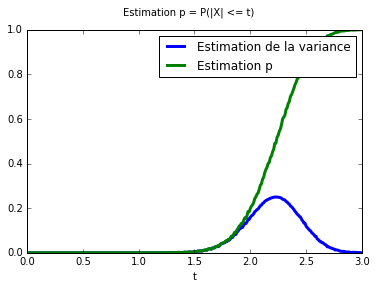

In [16]:
taille_echantillon = 10**4
dim = 15
valeurs_t = np.arange(0,3,.01)
estimation_p = np.zeros((len(valeurs_t),1))
for i in range(len(valeurs_t)):
    estimation_p[i] = estimationp(dim, taille_echantillon, valeurs_t[i])
plt.xlabel("t")
plt.plot(valeurs_t, estimation_p - np.power(estimation_p,2), label="Estimation de la variance")
plt.plot(valeurs_t, estimation_p, label="Estimation p")

plt.legend()
plt.xlabel("t")
plt.suptitle("Estimation p = P(|X| <= t)")

<p class="bg-primary" style="padding:1em">**QUESTION II.2.3.** Justifiez le choix de
$$ \frac{\sqrt{\widehat p(t) - \widehat p(t)^2}}{\widehat p(t)} $$
pour évaluer la précision de $\widehat p(t)$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.2.3.** 
Comme remarqué dans la question précédent, l'estimation de la variance seule ne doit être le meilleur critère pour étudier la précision de l'estimateur de Monte-Carlo. Il faudra tenir en compte l'ordre de grandeur des valeurs estimées aussi. Ce nouveau estimateur permet de faire exactement cela en prennant l'estimation de l'écart type et en le divisant par la valeur estimée.
</div>

<div class="alert alert-success center;">On définit **l'erreur relative** comme le rapport entre l'écart-type de l'estimateur et sa moyenne :
$$ \text{erreur relative } = \frac{\sqrt{\text{Var}(\widehat V)}}{E (\widehat V)} $$
En pratique, ces valeurs sont inconnues mais on peut les estimer par Monte-Carlo.</div>



<p class="bg-primary" style="padding:1em">**QUESTION II.2.4.** Reprenez et complétez le script précédent afin de tracer, sur une autre figure, la courbe $t \mapsto \sqrt{1/\widehat p(t) - 1}$. Pour quelles valeurs de $t$ l'estimateur vous semble-t-il être le moins précis ?</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.2.4.** 
On peut regarder dans le graphique que l'erreur relative diminue lorsque t augmente. Lorsque t tend vers 1, l'estimateur devient imprécis. On trouve donc que l'étude de la précision avec l'estimation de la variance, comme fait dans la question précédente, était faux. En effet, en reprennat ce que l'on avait vu dans le cas de la sphère, pour un nombre élevé de dimensions, les points dans le volume d'une sphère de rayon t, $\{X : \lVert X \rVert \leq t\}$, sont concentrés près de sa surface. Comme les variables aleatoires utilisées par Monte-Carlo sont distribuées uniformement dans l'hypercube $[-1, 1]^d$, pour t petit il y'aura beaucoup des points dans l'hypercube que ne sont pas dans le volume de la sphère. En augmentant t, plus de points y tombent dedans et ceci rend par conséquence l'estimation plus précise. 

</div>

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


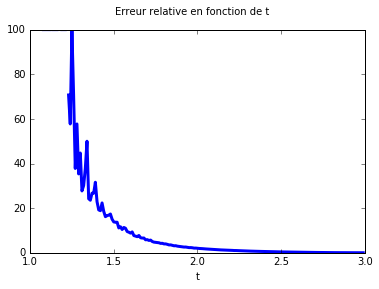

In [17]:
plt.xlabel("t")
plt.plot(valeurs_t, np.power(1.0 / estimation_p - 1.0 , .5), label="Erreur Relative")
plt.suptitle("Erreur relative en fonction de t")

On revient maintenant au cas de la sphère.

<p class="bg-primary" style="padding:1em">**$\star$ QUESTION II.2.5. $\star$** Montrez que dans ce cas, l'erreur relative de l'estimateur de Monte-Carlo est donnée par
$$ \frac{\sqrt{\text{Var}(\widehat V^{\text{MC}}_d)}}{E(\widehat V^{\text{MC}}_d)} = \frac{c_d}{\sqrt N} \ \text{ avec } \ c_d = \sqrt{\frac{2^d}{V_d}-1}. $$</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.2.5.** 
Comme calculé dans la question précédente:

$$Var\big[\widehat p(t)\big] = \frac{1}{N^2}(p(t)-p(t)^2)$$

Une fois que l'on a $\widehat V_d^{MC} = 2^d \widehat p(1)$:

$$Var\big[\widehat V_d^{MC}\big] = Var\big[2^d \widehat p(1)\big] = \frac{4^d}{N}(p(1) - p(1)^2) = \frac{1}{N}(2^dV_d - V_d^2)$$
$$ $$
$$E[\widehat V_d^{MC}] = V_d$$

$$ $$ 

$$\frac{\sqrt{Var[\widehat V_d^{MC}]}}{E[\widehat V_d^{MC}]} = \frac{1}{\sqrt{N}}\sqrt{\frac{2^d(V_d-V_d^2)}{V_d^2}} = \frac{1}{\sqrt{N}}\sqrt{\frac{2^d}{V_d}-1}$$

Q.E.D.


</div>

<p class="bg-primary" style="padding:1em">**QUESTION II.2.6.** Modifiez la fonction `estimation_IIDMC` de telle sorte à ce qu'elle calcule également l'erreur relative d'estimation du volume de la sphère. Tracez la courbe correspondante et commentez les résultats obtenus.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.2.6.** 
Ce que l'on constate d'abord c'est que l'estimation IIDMC suive approximativement la valeur théorique lorsque l'on augmente le nombre de dimensions. Les méthodes de sommes de Riemann présentent des oscillations pour les nombres de dimensions plus élevés, comme on l'avait déjà vu. L'écart relative de IIDMC oscille autour de zero tandis que Riemann présent des valeurs beaucoup plus hautes. Finalement, en augmentant le nombre de dimensions, l'erreur relative (la meilleure façon utilisé ici pour étudier la précision des méthodes), augmente de façon exponencielle (pour une taille d'échantillon fixée).
</div>

In [18]:
from fonctions_estimation import estimation_IIDMC

In [19]:
est_IIDMC = np.zeros([nb_dimensions,3])
val_th = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    val_th[i] = np.pi**(dim / 2.0) / special.gamma(dim / 2.0 + 1.0) 
    print '> Estimation par Monte Carlo en dimension:', dim
    # pour une comparaison juste, on prend la même taille d'échantillon que pour Riemann
    est_IIDMC[i,:] = estimation_IIDMC(dim, N)

> Estimation par Monte Carlo en dimension: 2
> Estimation par Monte Carlo en dimension: 3
> Estimation par Monte Carlo en dimension: 4
> Estimation par Monte Carlo en dimension: 5
> Estimation par Monte Carlo en dimension: 6
> Estimation par Monte Carlo en dimension: 7
> Estimation par Monte Carlo en dimension: 8
> Estimation par Monte Carlo en dimension: 9
> Estimation par Monte Carlo en dimension: 10
> Estimation par Monte Carlo en dimension: 11
> Estimation par Monte Carlo en dimension: 12
> Estimation par Monte Carlo en dimension: 13


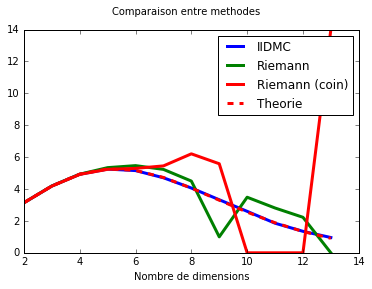

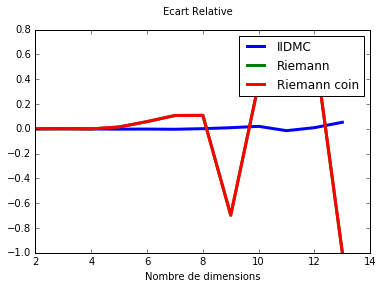

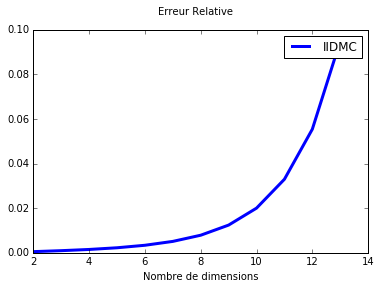

In [20]:
fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,0], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann (coin)")
plt.plot(dimensions, val_th, 'r--', label="Theorie")
plt.legend()
plt.xlabel("Nombre de dimensions")
fig.suptitle("Comparaison entre methodes")

fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,1], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann coin")
plt.legend()
plt.xlabel("Nombre de dimensions")
fig.suptitle("Ecart Relative")

fig = plt.figure()
errel_IIDMC, = plt.plot(dimensions, est_IIDMC[:,2], label="IIDMC")
plt.legend()
plt.xlabel("Nombre de dimensions")
fig.suptitle("Erreur Relative")

<h2>II.3. Limitations de la méthode IIDMC</h2>


On conclut cette partie par une limitation évidente de la méthode de Monte-Carlo.


<p class="bg-primary" style="padding:1em">**QUESTION II.3.1.** Que vaut $\widehat V^{\text{MC}}_{30}$ pour $N = 10^6$? Faites un calcul d'ordre de grandeur pour déterminer le nombre d'échantillons qu'il faudrait pour avoir une erreur relative $\leq 10^{-2}$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.3.1.**
Le calcul est presenté dans le ci-dessous:
$$ $$
$$\frac{\text{erreur relative}_{N=10^6}}{\text{erreur relative}_{N}} = \frac{1/\sqrt{10^6}}{1/\sqrt{N}}$$
$$ $$
$$ N = 10^6\bigg(\frac{\text{erreur relative}_{N=10^6}}{0.01}\bigg)^2$$

L'ordre de grandeur est de $10^{+17}$. Donc pour 30 dimensions, obtenir une erreur inférieure à 0.01 avec la méthode de Monte-Carlo naïf n'est pas faisable.
</div>

In [21]:
dim = 30
N = 10**6
print(N)
print 'Pour N=10^6 et dim = 30: ', estimation_IIDMC(dim, N)
nouvelle_erreur = 0.01
nouveau_n = N*((estimation_IIDMC(dim, N)[2])/(nouvelle_erreur))**2
print 'Pour une erreur relative < 0.01 => N >', nouveau_n 

1000000
Pour N=10^6 et dim = 30:  [0.0, -1.0, 6999.6398552715928]
Pour une erreur relative < 0.01 => N > 4.89949581035e+17


<p class="bg-primary" style="padding:1em"> **$\star$ QUESTION II.3.2. $\star$** Quel bilan tirez-vous de l'estimation d'intégrales par méthode de Monte-Carlo? </p>

<div class="alert alert-warning">**REPONSE A LA QUESTION II.3.2.**
Pour conclure, si d'un côté les méthodes de Riemann permettaient d'estimer l'integral à petits nombres de dimensions, une fois que ce nombre croise un certain seuil, la méthode n'est plus utilisable. On a vu que l'une des raisons était le fait que les méthodes de Riemann utilisent des points distribuées géometriquement dans une grille, ne prennant pas en compte la fonction qu'elles souhaitent estimer. Par contre, la méthode de Monte Carlo utilise des points aleatoires. On n'a que utilisé des distribuitions uniformes pour cela (donc on a pas pris en compte le fonction à intégrer non plus), mais on a déjà trouvé des résultats satisfatoires pour valeurs de dim supérieures. Pour dim fixée, cette méthode converge avec une vitesse de $1/\sqrt{N}$, supérieur à celle des sommes de Riemann. Toutefois, utiliser toujours des distribuitions uniformes n'est pas la meilleure solution comme on a pu constater. Il faudra trouver une meilleure façon d'utiliser les méthodes de Monte Carlo, surtout pour des valeurs de dim élevées.
</div>

<div class="alert alert-danger"><b>On a illustré ci-dessus la méthode de Monte-Carlo sur l'exemple du calcul de l'intégrale
$$ \int_{[-1,1]^d} \phi(x) d x \ {\bf {\text{ avec }}} \ \phi(x) = {\bf 1}(\lVert x \rVert \leq 1). $$
L'idée a été d'interpréter l'intégrale comme une espérance et d'utiliser la loi forte des grands nombres pour approcher cette espérance. Cette idée se généralise aisément au calcul de l'intégrale
$$ \int \phi(x) f(x) d x $$
où $f$ est une densité, en réécrivant cette intégrale comme l'espérance de la variable aléatoire $\phi(X)$ où $X$ est de densité $f$. Par ailleurs, contrairement au cas déterministe, la vitesse de convergence de cette méthode est indépendante de la dimension du problème!</b></div>




<a id="SIMUSTO"></a><h1 style="border: 5px solid; text-align: center; padding: 10px"> III. Eléments de simulation stochastique et méthode du rejet</h1>


<div class="alert alert-success"> On présente ici des éléments de simulation stochastique. On discute d'abord de méthodes pour vérifier qu'une variable aléatoire suit une loi donnée, puis on présente la méthode du rejet, qui permet de générer une variable aléatoire avec une loi donnée. Une autre méthode classique et très importante est la méthode de la fonction de répartition inverse qui fait l'objet du DM.</div>


<div class="alert alert-success">Nous verrons dans la suite du cours que la méthode du rejet est à la base de la technique d'échantillonnage préférentiel et des méthodes de Monte-Carlo à base de chaînes de Markov.</div>


<div class="alert alert-success">**Rappel**. La fonction de répartition d'une variable aléatoire $X$, notée $F_X$, est la fonction $F_X(x) = P(X \leq x)$.</div>



<h2> III.1. Histogramme et densité </h2>

Soit $X$ une variable aléatoire absolument continue que l'on sait générer mais dont on ne connaît pas la densité. Pour vérifier qu'une densité candidate $g$ est proche de la vraie densité, une manière très visuelle est de générer un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ et de comparer un histogramme associé à cet échantillon à $g$.

<p class="bg-primary" style="padding:1em">**QUESTION III.1.1.** Soit $(Y_k)$ i.i.d. qui suivent une loi exponentielle de paramètre $1/2$. Le théorème central limite prédit que
$$ X = \sum_{k=1}^{100} Y_k $$
suit approximativement une loi normale : quels sont les paramètres de cette loi ?</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.1.1.** 
D'abord, j'ai consideré que le paramètre de l'exponencielle donné était son espérance selon conseil du professeur. Ainsi, on a:

$$ Y_k \sim exp(1/2)$$
$$ $$
Donc, $\mu = 1/2$ et $\sigma^{2} = (1/2)^{2} = 1/4$. 

D'après le théorème central limite on sait que:
$$ $$

$$ \lim_{N\to\infty} \frac{\frac{1}{N} \big(\sum_{k=1}^N Y_k \big)- \mu}{\sqrt{\sigma^2 /N}} \sim N(0, 1)$$

Donc:

$$ \lim_{N\to\infty} \frac{\sum_{k=1}^N Y_k - N\mu}{\sqrt{\sigma^2 N}} \sim N(0, 1)$$

$$ $$
$$ \lim_{N\to\infty} \sum_{k=1}^N Y_k \sim N(N\mu, N\sigma^2)$$
$$ $$
Pour N = 100, on a que la somme de 100 variables aleatories $Y_k$ suive approximativement une distribuition normal comme ci-dessous:
$$ $$
$$\sum_{k=1}^{100} Y_k \space\dot\sim\space N(50,25)$$
</div>



<p class="bg-primary" style="padding:1em">**QUESTION III.1.2.** Vérifiez votre réponse en complétant le script suivant, et commentez les résultats obtenus.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.1.2.** 
En traçant l'histogramme e la fonction densité de la distribuition normal dont la somme suive approximativement, on constante une correspondance entre les deux, comme l'on savait déjà, d'après le théorème central limite.
</div>

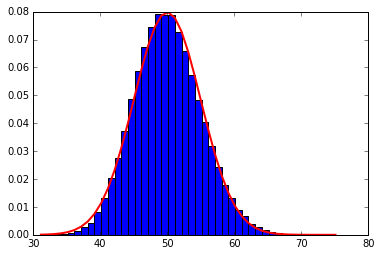

In [22]:
taille_echantillon = 10**5
nb_termes = 100
parametre_exp = .5
exp = np.zeros((nb_termes, taille_echantillon))
for i in range (nb_termes):
    exp[i] = np.random.exponential(parametre_exp, taille_echantillon)
    echantillon = np.sum(exp, axis = 0)
count, bins, ignored = plt.hist(echantillon, np.arange(np.min(echantillon)-0.5, np.max(echantillon)+1.5), normed=True)
mu = 100*parametre_exp
sigma = (parametre_exp)*nb_termes**0.5
plt.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma), linewidth=2, color='r')

<p class="bg-primary" style="padding:1em">**QUESTION III.1.3.** Discutez des limitations potentielles de cette méthode.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.1.3.** </div>

<h2> III.2. Fonction de répartition empirique </h2>

Nous présentons maintenant une méthode plus rigoureuse. On considère un échantillon $(X_1, X_2, \ldots)$ de variables i.i.d. distribuées comme $X$ à valeurs dans $R$ et on s'intéresse à la fonction
$$ \widehat F_N: x \in R \mapsto \frac{1}{N} \sum_{k=1}^N {\bf 1}(X_k \leq x). $$


<p class="bg-primary" style="padding:1em">**QUESTION III.2.1.** Montrez que $\widehat F_N(x) \to F_X(x)$ pour tout $x \in R$ fixé.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.2.1.** 
$$E[\widehat F_N] = E\bigg[\frac{1}{N}\sum_{k=1}^N \mathbb{1}(X_k \leq x)\bigg] = \frac{1}{N}\sum_{k=1}^N E[\mathbb{1}(X_k \leq x)]$$
$$ $$
Comme $X_k$ sont i.i.d., on appele $X$ une variable aleatoire i.i.d. avec $X_k$. Une fois que pour l'indicatrice on sait que $E[\mathbb{1}(X \leq x)] = P(X \leq x)$, alors:
$$ $$
$$E[\widehat F_N] = \frac{1}{N} NP(X\leq x) = F_X$$

D'après le théorème central limite:
$$\lim_{N\to\infty} \widehat F_N(x) = F_X(x) $$
</div>


Ce résultat justifie donc d'appeler $\widehat F_N$ **fonction de répartition empirique** de $X$. Pour vérifier qu'une variable aléatoire suit une loi de fonction de répartition $F$, on peut donc superposer $\widehat F_N$ et $F$ et accepter que $F = F_X$ si les deux courbes sont proches pour $n$ suffisamment grands.

<p class="bg-primary" style="padding:1em">**QUESTION III.2.2.** Complétez le script suivant pour vérifier que les fonctions ``stats.expon.rvs``, ``stats.gamma.rvs``, ``stats.uniform.rvs`` et ``stats.expon.rvs`` renvoient bien des variables aléatoires qui suivent la loi uniforme, la loi exponentielle, la loi de Poisson et la loi gamma, respectivement. Utilisez pour cela la fonction ``ecdf``. A partir de quelle taille d'échantillon les approximations vous semblent-elles valides ?</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.2.2.** 
On constate que les fonctions de distribuition empiriques s'approchent des valeurs théoriques lorsque la taille de l'échantillon est suffisamment grande. C'est difficile de definir un seuil dès lequel les approximations semblent valides, car cela depende du niveau de précision que l'on souhaite atteindre. Toutefois, pour N>100, les fontions empiriques sont déjà assez proches des théoriques, permettant de conclure que les variables aleatoires suivent en effet les distribuitions que l'on avait comme hypothèse au début.

</div>

In [23]:
def ecdf(echantillon):
    """
    Cette fonction prend en entrée un échantillon
    et renvoie le couple (sorted_, yvals) qui est tel que
    np.step(sorted_, yvals) trace la fonction de répartition empirique
    """
    sorted_ = np.sort(echantillon)
    yvals = np.arange(len(sorted_))/float(len(sorted_))
    sorted_ = np.append(sorted_, np.amax(echantillon))
    sorted_ = np.append(sorted_, np.amax(echantillon)+1)
    sorted_ = np.insert(sorted_, 0, np.amin(echantillon)-1)
    yvals = np.append(yvals, 1)
    yvals = np.append(yvals, 1)
    yvals = np.insert(yvals, 0, 0)
    return (sorted_, yvals)

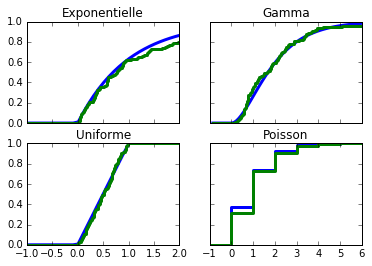

In [24]:
taille = 10**2
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

t = ["Exponentielle", "Gamma", "Uniforme", "Poisson"]
for i in range(4):
    if i==0: # exponentielle
        echantillon = stats.expon.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax1
        a.plot(x, stats.expon.cdf(x, loc=0, scale=1))
    if i==1: # gamma
        echantillon = stats.gamma.rvs(a=2, loc=0, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax2
        a.plot(x, stats.gamma.cdf(x, a=2, loc=0, scale=1))
    if i==2: # uniforme
        echantillon = stats.uniform.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax3
        a.plot(x, stats.uniform.cdf(x, loc=0, scale=1))
    if i==3: # poisson
        echantillon = stats.poisson.rvs(mu=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax4
        a.step(x, stats.poisson.cdf(x, mu=1))
    s, y = ecdf(echantillon)
    a.step(s, y)
    a.set_title(t[i])
    a.set_xlim([np.min(echantillon)-1, np.max(echantillon)+1])

<p class="bg-primary" style="padding:1em">**QUESTION III.2.3.** Soient $U_1$, $U_2$ indépendantes et uniformément réparties sur $[0,1]$ et $Z = \sqrt{- 2 \ln U_1} \cos(2 \pi U_2)$. Vous pouvez générer au plus 200 variables aléatoires. Parmi les choix suivants, quelle est selon vous la loi de $Z$?
<br>

&#9679; Cauchy, i.e., $f_Z(z) \propto 1/(1+z^2)$ (cf. ``stats.cauchy``)

<br>

&#9679; Laplace, i.e., $f_Z(z) \propto e^{-\lvert z \rvert}$ (cf. ``stats.laplace``)

<br>

&#9679; Gauss, i.e., $f_Z(z) \propto e^{-z^2/2}$ (cf. ``stats.norm``)</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.2.3.** 
On a une variable aleatoire Z dont la loi on ne connait pas. On utilise la méthode de la fonction de repartition empirique pour la trouver. La démarche était de générer des échantillons de valeurs aleatoires sélon $U_1$ et $U_2$, puis générer un échantillon de valeurs $Z$ selon la formule. Après il a fallu tracer la fonction de repartition empirique de Z e la comparer avec celles de Gauss, Cauchy et Laplace. Les résultats, en utilisant une taille maximale de 200 variables aleatoires, permettent de conclure que Z suive une loi de Gauss.
</div>

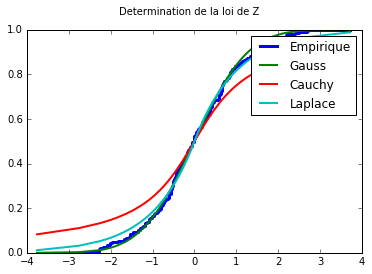

In [25]:
taille_echantillon = 200

u1 = stats.uniform.rvs(loc=0, scale=1, size=taille_echantillon)
u2 = stats.uniform.rvs(loc=0, scale=1, size=taille_echantillon)
z =  ((-2*np.log(u1))**.5)*np.cos(2*np.pi*u2)

s,y = ecdf(z)
plt.step(s,y, label="Empirique")
plt.plot(s, stats.norm.cdf(s, loc=0, scale=1), linewidth=2, label="Gauss")
plt.plot(s, stats.cauchy.cdf(s, loc=0, scale=1), linewidth=2, label="Cauchy")
plt.plot(s, stats.laplace.cdf(s, loc=0, scale=1), linewidth=2, label="Laplace")
plt.legend()
plt.suptitle("Determination de la loi de Z")

Jusqu'à présent, la méthode proposée n'est pas beaucoup plus rigoureuse que l'utilisation des histogrammes, à la différence qu'il n'y a pas besoin de faire de choix pour les urnes. Un autre avantage est que la vitesse de convergence $\widehat F_N \to F_X$ peut être quantifiée comme on le voit maintenant.

<p class="bg-primary" style="padding:1em">**$\star$ QUESTION III.2.4. $\star$** Quel résultat contrôle les fluctuations de $\widehat F_N(x)$ autour de $F_X(x)$? Montrez que
$$ P \left( \widehat F_N(x) - \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95 \ \text{ où } \ \varepsilon_N(x) = \frac{\sigma(x) F^{-1}(0{,}975)}{\sqrt N} $$
avec $\sigma(x)^2 = F_X(x) (1-F_X(x))$, $F$ la fonction de répartition de la loi normale centrée réduite et $F^{-1}$ son inverse.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.2.4.** 

La variable aleatoire $\mathbb{1}(X_k \leq x)$ a pour esperance $E[\mathbb{1}(X_k \leq x)] = P(X_k \leq x) = F_X(x)$. Sa variance est donnée par $\sigma^2(x)$. On sait d'après le théorème central limite que, lorsque $N \rightarrow \infty$:

$$ $$

$$\frac{\frac{1}{N}\sum_{k=1}^N\mathbb{1}(X_k \leq x) - F_X(x)}{\sigma(x) \big/ \sqrt{N}} = \frac{\widehat F_N(x) - F_X(x)}{\sigma(x) \big/ \sqrt{N}} \sim N(0,1)$$
$$ $$
Si l'on reécrit maintenant la probabilité qui l'on souhaite calculer comme ci-dessous:
$$ $$
$$P \left(- \varepsilon_N(x) \leq F_X(x) - \widehat F_N(x) \leq \varepsilon_N(x) \right)$$
$$ $$
$$= P \bigg(-F^{-1}(0.975) \leq \frac{F_X(x) - \widehat F_N(x)}{\sigma(x)\big/\sqrt{N}} \leq F^{-1}(0.975)\bigg)$$
$$ $$
Ainsi:

$$\lim_{N\to\infty} P \bigg(-F^{-1}(0.975) \leq \frac{F_X(x) - \widehat F_N(x)}{\sigma(x)\big/\sqrt{N}} \leq F^{-1}(0.975)\bigg) = F(F^{-1}(0.975)) - F(-F^{-1}(0.975))$$
$$ $$
$$= 0.975 - (1-0.975) = 0.975 - 0.025 = 0.95 $$

Q.E.D.
$$ $$
Les fluctuations varient avec $1\sqrt{N}$. Une vitesse de convergence égale à celle de Monte-Carlo.
</div>


<p class="bg-primary" style="padding:1em">**$\star$ QUESTION III.2.5. $\star$** Quel est le problème de la fonction $\varepsilon_N$? Proposez une fonction $\widehat \varepsilon_N$ sans ce problème et qui satisfait aussi
$$ P \left( \widehat F_N(x) - \widehat \varepsilon_N(x) \leq F_X(x) \leq \widehat F_N(x) + \widehat \varepsilon_N(x) \right) \mathop{\longrightarrow}_{n \to \infty} 0{,}95. $$</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.2.5.** 
Une fois que l'on utilise la méthode de la fonction de repartition lorsque on ne connait pas la distribuition d'une variable aleatoire, on ne connait non plus sa variance $\sigma^2(x)$ (ou l'écart-type). Cependant, on peut utiliser son estimateur au lieu d'elle-même, i.e. $\widehat{\sigma^2}(x)$. 
$$ $$
$$\widehat{\sigma^2}(x) = \widehat F_X(x) (1-\widehat F_X(x))$$

On voit facilement que:

$$E[\widehat{\sigma^2}(x)] = F_X(x) (1-F_X(x)) = \sigma^2(x)$$
$$ $$
Comme le résultat de la question précédent a été obtenu en faisant $N \rightarrow \infty$, et une fois que $\lim_{N\to\infty} \widehat{\sigma^2}(x) = \sigma^2(x)$, le résultat est encore valable si on changue la variance pour son estimateur, c'est-à-dire:
$$ $$
$$\widehat\varepsilon_N(x) = \frac{\sqrt{\widehat{\sigma^2}(x)} F^{-1}(0{,}975)}{\sqrt N}$$


</div>



On remarquera en particulier que $[\widehat F_N(x) - \widehat \varepsilon_N(x), \widehat F_N(x) + \widehat \varepsilon_N(x)]$ est l'**intervalle de confiance bilatéral symétrique** de $F_X(x)$ au niveau asymptotique $95\%$.

<p class="bg-primary" style="padding:1em">**$\star$ QUESTION III.2.6. $\star$** Reprenez et complétez le script précédent pour ajouter les deux enveloppes $\widehat F_{100} \pm \widehat \varepsilon_{100}$. Utilisez pour cela les fonctions ``np.std`` et ``stats.norm.ppf``.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.2.6.** 
    À rouge on peut regarder les deux courbes que definent l'interval de confiance bilatéral symétrique de $F_X(x)$ à $95\%$. Elles signifient que on a $95\%$ de chance que la vraie fonction de distribuition y tombe dedans. Si l'on fait diminuer la taille de l'échantillon, l'écart entre ces deux lignes augment car $\widehat\varepsilon_N(x)$ augmente aussi (selon $1/\sqrt{N}$, comme l'on avait vu). Pour $N=10^3$, elles sont déjà vraiment proches l'une de l'autre et des distribuitions théoriques, que dans ce cas on connait.
</div>

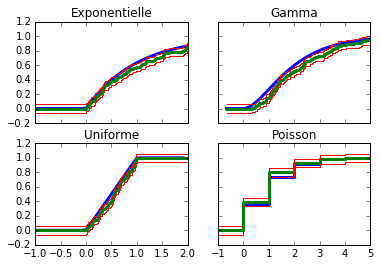

In [26]:
taille = 10**2
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

t = ["Exponentielle", "Gamma", "Uniforme", "Poisson"]
for i in range(4):
    if i==0:
        echantillon = stats.expon.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax1
        a.plot(x, stats.expon.cdf(x, loc=0, scale=1))
    if i==1:
        echantillon = stats.gamma.rvs(a=2, loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax2
        a.plot(x, stats.gamma.cdf(x, a=2, loc=0, scale=1))
    if i==2:
        echantillon = stats.uniform.rvs(loc=0, scale=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax3
        a.plot(x, stats.uniform.cdf(x, loc=0, scale=1))
    if i==3:
        echantillon = stats.poisson.rvs(mu=1, size=taille)
        x = np.arange(np.min(echantillon)-1, np.max(echantillon)+1, .1)
        a = ax4
        a.step(x, stats.poisson.cdf(x, mu=1))
    s, y = ecdf(echantillon)
    ecart_type = np.std(y)
    a.step(s, y)
    a.set_title(t[i])
    epsilon = (ecart_type*stats.norm.ppf(0.975,loc=0, scale=1)) / ((taille**.5)) 
    a.step(s,y + epsilon, 'r', linewidth=1.0)
    a.step(s,y - epsilon, 'r', linewidth=1.0)
    a.set_xlim([np.min(echantillon)-1, np.max(echantillon)+1])
    

<h2> III.3. Méthode du rejet </h2>

Soit $Y$ une variable aléatoire absolument continue admettant pour densité $f$ satisfaisant $f(x) = 0$ si $\lvert x \rvert \geq 1$ et $\sup f < \infty$. On génère itérativement des points uniformément répartis sur $[-1,1] \times [0,K]$ avec $K \geq 2\sup f$ jusqu'à avoir généré un point sous la courbe $f$. Sur la figure ci-dessous, on a généré les quatre croix avant de générer le point noir.

![title](rejet.png)



On considère alors l'abscisse du premier point sous la courbe, que l'on note $Z$. Dans le premier devoir maison, on vous demande de démontrer que
$$ \tag{1} P(Z \leq z) = P(X \leq z \mid U \leq f(X)), \ z \in R, $$
avec $(X, U)$ uniformément réparti sur $[-1,1] \times [0,K]$.

<p class="bg-primary" style="padding:1em">**QUESTION III.3.1.** Donnez la densité de $(X, U)$ et déduisez de (1) que $Z$ admet $f$ pour densité.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.3.1.**
Les calculs suivants ont été fait en prennant en compte que U et X sont i.i.d.:
$$ $$
$$f_{XU}(x,u) = \frac{1}{2K}\mathbb{1}(|X| \leq 1, 0 \leq U \leq K) = \frac{1}{2K}\mathbb{1}(|X| \leq 1)\mathbb{1}(0 \leq U \leq K)$$
$$ $$
$$ P(X \leq z \mid U \leq f(X)) = \frac{\int\int f_{XU}(x,u) dudx}{\int f_U(u) du} = \frac{\frac{1}{2K}\int_{-\infty}^{z}\mathbb{1}(|x| \leq 1)dx \int_{-\infty}^{f(X)} \mathbb{1}(0 \leq u \leq K) du}{\int_{-\infty}^{f(X)} \frac{1}{K}\mathbb{1}(0 \leq u \leq K) du} = F_X(z) $$

$$ $$
Donc:
$$P(Z \leq z) = F_Z(z) = F_X(z)$$
$$ $$
$$f_Z(z) = \frac{dF_Z(z)}{dz} = \frac{dF_X(z)}{dz} = f_X(z)$$

Q.E.D.
</div>


<p class="bg-primary" style="padding:1em">**QUESTION III.3.2.** Quelle est la loi du nombre de points rejetés avant d'en accepter un ? En déduire le nombre moyen de simulations nécessaires afin de simuler $Y$ selon cette méthode.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.3.2.** 
La loi est géometrique. Soit p la probabilité d'accepter un point, i.e. $p = P(U \leq f_X(x))$ et W la variable aleatoire correspondent au nombre de points rejectés avant accepter un.
$$ $$

$$P(W = w) = (1-p)^{w-1}p$$

$$ $$
Le nombre moyen de simulations necessaire pour accepter un point (i.e. pour simuler Y) est donné par l'ésperance de la loi géometrique, i.e. $1/p$.

</div>




<p class="bg-primary" style="padding:1em">**QUESTION III.3.3.** Ecrivez un script qui implante cette méthode dans le cas où $f$ est la densité normale tronquée, i.e.,
$$ f(x) \propto \exp\left( -\frac{x^2}{2} \right) {\bf 1}(-1 \leq x \leq 1). $$
Vous vérifierez bien que la sortie de votre script admet la bonne loi.

<div class="alert alert-warning">**REPONSE A LA QUESTION III.3.3.** 
Le graphique montre que les fonctions de repartition théorique et empirique sont proches l'une de l'autre. Comme vu précédemment, on pouvait diminuer encore plus l'écart entre elles en augmentant N.
</div>

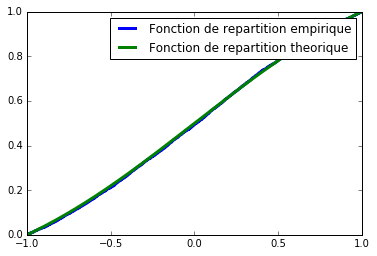

In [27]:
taille_echantillon = 10**4

Z1 = stats.norm.cdf(np.arange(-1, 1, .0001), loc=0, scale=1)

Z = ((2*np.pi)**.5) * (Z1[len(Z1)-1]-Z1[0])
K = 2/Z
x = stats.uniform.rvs(loc=-1, scale=2, size=taille_echantillon)
u = stats.uniform.rvs(loc=0, scale=K, size=taille_echantillon)

echantillon = []

for i in range(taille_echantillon):
    fx = np.exp(-(x[i])**2/2)
    if (u[i] < fx):
        echantillon.append(x[i])
s, y = ecdf(echantillon)
s = s[1:-1]
y = y[1:-1]
plt.step(s, y, label="Fonction de repartition empirique")
plt.plot(s, (stats.norm.cdf(s)-stats.norm.cdf(-1))/(stats.norm.cdf(1)-stats.norm.cdf(-1)), label= "Fonction de repartition theorique")
plt.legend()

<p class="bg-primary" style="padding:1em">**QUESTION III.3.4.** A l'aide de la méthode du rejet, écrivez un code qui permet de générer une variable aléatoire de densité $\displaystyle f(x) \propto \lvert x \rvert \exp(\lvert x \rvert^\pi) {\bf 1}(\lvert x \rvert < 1)$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION III.3.4.**
J'ai utilisé la même procedure qu'avant. En plus j'ai intégré numériquement la densité donné pour comparer les fonctions de repartition théorique et empirique. Elles ne diffèrent que par une constante multiplicative.
</div>

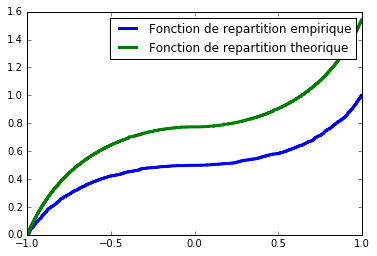

In [28]:
from scipy.integrate import quad

def integrand(x):
    return np.absolute(x)*np.exp(np.absolute(x)**np.pi)*np.sign(x-1)*np.sign(-x-1)

taille_echantillon = 10**4
K = 2*np.exp(1)
x = stats.uniform.rvs(loc=-1, scale=2, size=taille_echantillon)
u = stats.uniform.rvs(loc=0, scale=K, size=taille_echantillon)

echantillon = []
for i in range(taille_echantillon):
    fx = np.absolute(x[i])*np.exp((np.absolute(x[i]))**np.pi)
    if (u[i] < fx):
        echantillon.append(x[i])
s, y = ecdf(echantillon)
s = s[1:-1]

theorie = []
for j in range(len(s)):
    I = quad(integrand, -1, s[j])
    theorie.append(I[0])

y = y[1:-1]
plt.step(s, y, label="Fonction de repartition empirique")
plt.step(s, theorie, label="Fonction de repartition theorique")
plt.legend()





<a id="IS"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">IV. Méthodes de réduction de variance</h1>


<div class="alert alert-success"> Pour améliorer l'estimation de $I = \int \phi f$, l'idée des méthodes de réduction de variance (aussi appelées échantillonnage préférentiel) est d'utiliser une représentation différente de l'intégrale :
$$ I = \int \phi f = \int \widetilde{\phi} g \ \text{ avec } \widetilde \phi = \frac{\phi f}{g} $$
puis d'utiliser l'estimateur IIDMC
$$ \frac{1}{N} \sum_{k=1}^N \widetilde \phi(Y_k) $$
où les $(Y_k)$ sont i.i.d. de densité $g$. Vous verrez dans le DM2 que cette méthode a des liens profonds avec la méthode du rejet.</div>

<h2> IV.1. Exemple de la loi de Cauchy </h2>

On cherche dans cette partie à estimer la probabilité $p=P(X>2)$ où $X$ suit une loi de Cauchy, i.e., $X$ est une variable aléatoire absolument continue de densité
$$ f(x) = \frac{1}{\pi (1+x^2)}, \ x \in R. $$
Pour cela, on va considérer $4$ estimateurs de Monte-Carlo:
$$ \widehat p^i_N = \frac{1}{N} \sum_{k=1}^N Y^i_k $$
où pour chaque $i=1,\dots,4$ les $(Y^i_k, k \in N)$ sont i.i.d.. Ces 4 estimateurs correspondent aux différentes écritures suivantes de $p$ :
\begin{align*}
p & = \int {\bf 1}(x > 2)  f(x) d x \tag{1}\\
& = \frac{1}{2} \int  {\bf 1}(\lvert x \rvert > 2) f(x) d x \tag{2}\\
& = \frac{1}{2} - \int  f(x){\bf 1}(0 \leq x \leq 2) d x \tag{3}\\
& = \int_0^{1/2} \frac{y^{-2}}{\pi (1 + y^{-2})} d y\tag{4}
\end{align*}
(1) vient de la définition de $p$, (2) de la parité de $f$, (3) du fait que $f$ s'intègre à $1$ et est paire, et (4) vient de (1) et du changement de variable $y = 1/x$.


<p class="bg-primary" style="padding:1em">**QUESTION IV.1.1.** Justifiez que le meilleur estimateur soit celui qui corresponde à la variable aléatoire $Y^i_1$ de variance minimale.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.1.1.** 
<p>Tous les 4 estimateurs ont la même esperance. En effet, pour i = 1, ..., 4, on a:</p>

$$ $$
$$E[\widehat p_N^i] = p$$
$$ $$
Selon le théorème central limite on sait que l'écart entre la valeur estimée et la probabilité souhaitée suive approximativement (pour N suffisament grand), une loi normale:
$$ $$
$$ \widehat p_N^i - p \space\dot\sim\space N\bigg(0,\frac{\sigma^2_i}{N}\bigg)$$
où $\sigma^2_i$ est la variance de $\widehat p_N^i$.
$$ $$
Donc pour la même taille d'échantillon, la variance minimale de la différence $\widehat p_N^i - p$ est obtenue pour l'estimateur dont la variance est minimale. Une fois que pour $\frac{\sigma^2_i}{N}$ minimale la différence $\widehat p_N^i - p$ a une probabilité plus grande d'être proche de zero, le meilleur estimateur est celui dont la variance est minimale. 
Comme $\sigma_{Y_1^i}^2 = \frac{\sigma_i^2}{N^2}$, pour N fixe, si la variance de l'estimateur est minimale, la variance de $Y_1$ l'est aussi (comme $Y_k$ sont i.i.d., les variances de $Y_k$ sont égales pour $k=1,...,N$).


</div>


<p class="bg-primary" style="padding:1em">**QUESTION IV.1.2.** $\widehat p^1$ correspond à l'estimateur naïf de Monte-Carlo : écrivez $Y^1_1 = \varphi_1(X)$ et estimez numériquement $\text{Var}(Y^1_1)$ dans ce cas.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.1.2.** 
$$ p = \int\mathbb{1}(x > 2)f(x)dx = E[\mathbb{1}(X>2)]$$
où X sont tirés selon f. L'estimateur est donc donné par:
$$ $$
$$ \widehat p_N^1 = \frac{1}{N}\sum_{k=1}^N\mathbb{1}(X_k>2) $$
Dans ce cas:
$$Y^1_1 = \mathbb{1}(X_1>2)$$

</div>

In [29]:
def methode1(N):   
    taille_echantillon = N
    x = np.random.standard_cauchy(taille_echantillon)
    y = []
    for i in range(taille_echantillon):
        if x[i] > 2:
            y.append(1.0)
        else:
            y.append(0.0)
    estimation = (1.0 / taille_echantillon) * np.sum(y)
    variance_y = np.var(y, ddof=0)
    return [estimation, variance_y]
methode1(10**3)

[0.14499999999999999, 0.12397499999999996]

<p class="bg-primary" style="padding:1em">**QUESTION IV.1.3.** Utilisez la représentation (2) pour construire $Y^2_1 = \varphi_2(\lvert X \rvert)$. Estimez numériquement $\text{Var}(Y^2_1)$ dans ce cas et justifiez théoriquement la réduction de variance.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.1.3.** 
$$ p = \frac{1}{2}\int\mathbb{1}(|x| > 2)f(x)dx = E[\mathbb{1}(X>2)]$$
$$ $$
où X sont tirés selon f. L'estimateur est donc donné par:
$$ $$
$$ \widehat p_N^2 = \frac{1}{N}\sum_{k=1}^N\frac{\mathbb{1}(|X_k|>2)}{2} $$
$$ $$
Dans ce cas:
$$ Y_1^2 = \frac{\mathbb{1}(|X_1|>2)}{2} $$

</div>

In [30]:
def methode2(N):
    taille_echantillon = N
    x = np.random.standard_cauchy(taille_echantillon)
    y = []
    for i in range(taille_echantillon):
        if np.absolute(x[i]) > 2.0:
            y.append(0.5)
        else:
            y.append(0.0)
    estimation =  np.mean(y)
    variance_y = np.var(y, ddof=0)
    return [estimation, variance_y]
methode2(10**3)

[0.14699999999999999, 0.051890999999999993]

<p class="bg-primary" style="padding:1em">**QUESTION IV.1.4.** Utilisez la représentation (3) pour construire $Y^3_1 = \varphi_3(U)$ où $U$ est uniformément répartie, et estimez numériquement $\text{Var}(Y^3_1)$ dans ce cas.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.1.4.** 
$$ p = \frac{1}{2} - \int\mathbb{1}(0 \leq x \leq 2)f(x)dx = \frac{1}{2} - 2\int\frac{\mathbb{1}(0 \leq x \leq 2)}{2}f(x)dx $$

$$ $$
$$= E\bigg[\frac{1}{2}-2f(X)\mathbb{1}(0 \leq X \leq 2)\bigg]$$
$$ $$
où $X$ est uniformement répartie dans $[0, 2]$. L'estimateur est donc donné par:
$$ $$
$$ \widehat p_N^3 = \frac{1}{N}\sum_{k=1}^N\bigg(\frac{1}{2} - 2f(X_k)\mathbb{1}(0 \leq X_k \leq 2)\bigg) = \frac{1}{N}\sum_{k=1}^N\bigg(\frac{1}{2} - 2f(X_k)\bigg) $$
Dans ce cas:
$$Y^3_1 = \frac{1}{2} - 2f(X_1)$$
</div>

In [31]:
def methode3(N):
    taille_echantillon = N
    x = np.random.uniform(0, 2, taille_echantillon)
    y = []
    for j in range(taille_echantillon):
        y.append(.5 - 2/(np.pi*(1+x[j]**2)))
    estimation = np.mean(y)
    variance_y = np.var(y, ddof=0)
    return [estimation, variance_y]
methode3(10**3)

[0.15516805100169262, 0.02838404095946797]

<p class="bg-primary" style="padding:1em">**QUESTION IV.1.5.** Utilisez la représentation (4) pour construire $Y^4_1 = \varphi_4(U)$ où $U$ est uniformément répartie, et estimez numériquement $\text{Var}(Y^4_1)$ dans ce cas.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.1.5.** 

$$ p = \int_0^{\frac{1}{2}}\frac{x^{-2}}{\pi(1+x^{-2})}dx = \int\frac{x^{-2}}{\pi(1+x^{-2})}\mathbb{1}\bigg(0 \leq x\leq \frac{1}{2}\bigg)dx = \frac{1}{2}\int\frac{x^{-2}}{\pi(1+x^{-2})}\frac{\mathbb{1}\big(0 \leq x \leq \frac{1}{2}\big)}{1/2}dx $$

$$ $$
$$= E\bigg[\frac{X^{-2}}{2\pi(1+X^{-2})}\mathbb{1}(0 \leq X \leq 1/2)\bigg]$$
où $X \sim U[0, 1/2]$. L'estimateur est donc donné par:
$$ $$
$$ \widehat p_N^4 = \frac{1}{N}\sum_{k=1}^N\frac{X_k^{-2}}{2\pi(1+X_k^{-2})}$$
Dans ce cas:
$$Y^4_1 = \frac{X_1^{-2}}{2\pi(1+X_1^{-2})}$$

</div>

In [32]:
def methode4(N):
    taille_echantillon = N
    x = np.random.uniform(0.0, 0.5, taille_echantillon)
    y = []
    for i in range(taille_echantillon):
        y.append((np.power(1.0/x[i], 2.0))/(2.0 * np.pi*(1+np.power(1.0/x[i], 2.0))))
    estimation = np.mean(y)
    variance_y = np.var(y, ddof=0)
    return [estimation, variance_y]
methode4(10**3)

[0.14764353804672969, 9.7488370055380354e-05]

#### <p class="bg-primary" style="padding:1em">**QUESTION IV.1.6.** En reprenant les codes ci-dessus, calculez pour chacun de ces 4 estimateurs la taille de l'échantillon minimale qui permet d'estimer $p$ avec une erreur relative inférieure à $10^{-2}$ et commentez les résultats obtenus.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.1.6.** 
$$\text{erreur relative} = \frac{\sqrt{Var\big[\widehat p_N^i\big]}}{E\big[\widehat p_N^i\big]} = \frac{\sqrt{\frac{1}{N^2}Var\big[\widehat Y^i\big]}}{E\big[Y^i\big]}$$
$$ $$
$$ \text{erreur relative} < 10^{-2} \Leftrightarrow \frac{\sqrt{\frac{1}{N}Var\big[\widehat Y^i\big]}}{E\big[Y^i\big]} < 10^{-2} $$
$$ $$
Donc on calcul la taille minimale de l'échantillon comme suit:
$$ $$
$$ N > \frac{1}{10^4}\frac{Var\big[Y^i\big]}{E\big[Y^i\big]^2} $$
</div>

In [33]:
taille_echantillon = 10**5
for j in range(4):
    if j == 0:
        data = methode1(taille_echantillon)
    elif j == 1:
        data = methode2(taille_echantillon)
    elif j == 2:
        data = methode3(taille_echantillon)
    elif j == 3:
        data = methode4(taille_echantillon)       
    nb_echa = int(np.power(10.0, 4)*np.power(data[1]/data[0]**2, 1))   
    print "> Pour l'estimateur", j+1,', il faut un échantillon de taille', nb_echa

> Pour l'estimateur 1 , il faut un échantillon de taille 57750
> Pour l'estimateur 2 , il faut un échantillon de taille 23802
> Pour l'estimateur 3 , il faut un échantillon de taille 13055
> Pour l'estimateur 4 , il faut un échantillon de taille 43


<h2> IV.2. Echantillonnage préférentiel </h2>


Soit $g$ une densité de probabilité, appelée, comme pour le rejet, densité auxiliaire dans le cadre de l'échantillonnage préférentiel, telle que $g(x) = 0 \Rightarrow f(x) = 0$ si bien que le rapport $f(x) / g(x)$, et donc l'intégrale
$$ \int \phi \frac{f}{g} g, $$
sont bien définis si l'on adopte la convention $0/x = 0$ pour tout $x \in R$. Soit $(Y_k, k \in N)$ des variables i.i.d. de densité $g$ et
$$ \widehat I^g_N = \frac{1}{N} \sum_{k=1}^N \phi(Y_k) \frac{f(Y_k)}{g(Y_k)} $$


<p class="bg-primary" style="padding:1em">**QUESTION IV.2.1.** Montrez que $\widehat I^g_N$ est un estimateur sans biais et convergent de $I$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.2.1.** 
$$E\bigg[\frac{1}{N}\sum_{k=1}^N\phi(Y_k)\frac{f(Y_k)}{g(Y_k)}\bigg] = \int\phi(y)\frac{f(y)}{g(y)}g(y)dy = \int\phi(y)f(y)dy = I$$
$$ $$
J'ai utilisé juste la définiton d'ésperance et le fait que $Y_k$ sont tirées selon $g$. L'estimateur est donc centré Q.E.D., et selon la loi des grands nombres, il converge vers $I$ lorsque $N\rightarrow \infty$.

</div>



<p class="bg-primary" style="padding:1em">**QUESTION IV.2.2.** On suppose que $\phi \geq 0$ et l'on considère $g_{\text{opt}} = \phi f / I$. Montrez que $g_{\text{opt}}$ est une densité de probabilité lorsque $\phi \geq 0$, et montrez sans calcul que $\widehat I^{g_{\text{opt}}}_N$ est de variance nulle.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.2.2.** 
Une fois que $f$ est une densité de probabilité: $f(x) \geq 0$ pour tout $x$ réel. On suppose $\phi(x) \geq 0$ pour tout $x$ réel aussi. Donc $I = \int \phi f \geq 0$ et:

$$ $$
$$ \int g_{opt} = \int \frac{\phi f}{I} = \frac{1}{I} \int\phi f = 1 $$

$$ $$
Comme $g_{opt} \geq 0$ et son integral est égal à 1, $g_{opt}$ peut être vue comme une densité de probabilité Q.E.D.
Intuitivement, en utilisant cette fonction $g$, les valeurs dans notre somme ne sont plus aleatoires mais tous égales à $I$. L'estimateur n'est non plus une variable aleatoire et par conséquence sa variance est nulle. 
</div>



<p class="bg-primary" style="padding:1em">**QUESTION IV.2.3.** Que vaut $g_{\text{opt}}$ dans le cas de la sphère ? Peut-on l'utiliser ?</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.2.3.** 
Dans le cas de la sphère, on a:
$$ $$
$$V_d = \int_{[-1, 1]^d}\mathbb{1}(\lVert x \rVert \leq 1)dx = \int_{[-1, 1]^d}\frac{\mathbb{1}(\lVert x \rVert \leq 1)}{g_{opt}(x)}g_{opt}(x)dx$$

$$ $$
Avec $g_{opt}(x) = \frac{f(x)}{V_d}$. Si l'on connaît auparavant le volume que l'on souhaite estimer, alors on peut calculer $V_d$ et utiliser $g_{opt}(x)$.

</div>






<div class="alert alert-success"> Le problème de $g_{\text{opt}}$ est qu'elle dépend de la quantité $I$ que l'on cherche à estimer : **elle n'est donc pas utilisable en pratique mais cela suggère de chercher une densité auxiliaire qui lui soit proche.** En pratique, on se donne une famille paramétrique $\{g_\theta, \theta \in \Theta\}$ et on va chercher la "meilleure" fonction $g$ au sein de cette famille.</div>



Pour illustrer cette démarche, on reprend le problème d'estimation du volume de la sphère en dimension $30$. A la fin du BE précédent, nous avons en effet vu que l'estimateur naïf de Monte-Carlo n'était pas efficace dans ce cas. Pour cela, on considère la famille paramétrique $\{g_\theta, \theta > 0\}$ sur $R^d$ où
$$ g_\theta(x) = \prod_{k=1}^d h_\theta(x_k) \ \text{ avec } \ h_\theta(x_1) \propto (1-x_1^2)^{\theta-1} {\bf 1}(x_1 \in [-1,1]), \ x = (x_1, \ldots, x_d) \in R^d. $$

On notera $\widehat V^{\text{IS}(\theta)}_d$ l'estimation de $V_d$ obtenue par échantillonnage préférentiel en utilisant $g_\theta$ comme fonction auxiliaire.



<p class="bg-primary" style="padding:1em">**QUESTION IV.2.4.** Utilisez le script suivant pour tracer en dimension $d = 2$ la surface $g_\theta$ pour différentes valeurs de $\theta$, et expliquez intuitivement pourquoi, en grande dimension, il devrait être plus efficace de générer selon $g_\theta$ que selon $f$ lorsque $\theta > 1$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.2.4.** 
On avait vu que lorsque le nombre dimensions tendait vers l'infini, le volume de la sphère se concentré dans sa surface. Pour une grande dimension ce serait donc plus utile d'y placer plus de points qu'ailleurs. La fonction densité de probabilité $g_{opt}^{\theta}$ permet de faire cela tandis que en utilisant $f$ on placerait des points uniformement dans $[-1, 1]^d$.

</div>

In [34]:
def g(x, theta):
    '''
    x est une matrice avec N lignes et d colonnes
    d est la dimension de l'espace
    N est la taille de l'echantillon
    la fonction renvoie un vecteur de longueur N où la kième entrée correspond à la fonction g
    appliquée à la kième ligne
    '''
    dimension = x.shape[1]
    taille_echantillon = x.shape[0]
    c =(2 * special.gamma(2*theta) )/ (4**np.float64(theta) * special.gamma(theta)**2)
    return c**dimension * np.power(np.prod(1 - np.power(np.float64(x), 2), 1), (np.float64(theta) - 1))

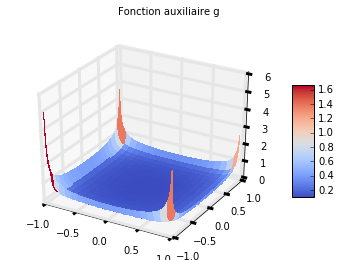

In [35]:
theta = 0.5
x = np.arange(-.99,.99,.01)
y = np.arange(-.99,.99,.01)
X, Y = np.meshgrid(x, y, indexing='ij')
Z = np.zeros(X.shape)
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j] = g(np.array([[x[i], y[j]]]), theta)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.suptitle("Fonction auxiliaire g")
plt.show()

On admet par la suite que si les $(Y_k)$ sont i.i.d. et suivent une loi beta de paramètre $(\theta, \theta)$, alors $g_\theta$ est la densité de $(2Y_k-1, k = 1,\ldots, d)$. Ainsi, pour générer une variable aléatoire de densité $g_\theta$, il suffit de savoir générer des variables aléatoires suivant la loi beta, ce que fait la fonction ``np.random.beta``.



<p class="bg-primary" style="padding:1em">**QUESTION IV.2.5.** Complétez le script suivant puis utilisez-le pour tracer la performance (estimation, écart relatif et erreur relative) de l'estimateur par échantillonnage préférentiel pour $N = 10^5$, $d \in [2,20]$ et $\theta = 7,5$. Comparez avec IIDMC. Que pensez-vous des résultats obtenus ? Analysez notamment l'influence du paramètre $\theta$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.2.5.** 
Lorsque l'on augmente le $\theta$ dès 1.0 à 7.5, les résultats, plutôt pour dimensions plus grandes, deviennet plus satisfactoires. Tandis que l'estimateur naïf n'est pas utilisable pour dimensions supérieurs à 10, l'échantillonage préferentielle permet d'aller jusqu'à 20. Toutefois l'erreur relative devient pire pour les dimensions plus baisses, comme l'on peut constater d'après le graphique. Si $\theta$ dépasse 7.5, l'erreur à baisses dimensions augmente encore plus.
</div>

In [38]:
def estimation_IS(dimension, taille_echantillon, theta):
    echantillon = 2*np.random.beta(theta, theta, size=(taille_echantillon, dimension)) - 1
    fonction_g = g(echantillon, theta)
    y = []
    for i in range(taille_echantillon):
        if (np.linalg.norm(echantillon[i,:],2) <= 1.0):
            y.append(1.0 / fonction_g[i])
        else:
            y.append(0.0)
    estimation = np.mean(y)
    V_theorique = (np.pi**(dimension / 2.0)) / special.gamma((dimension / 2.0) + 1.0) 
    ecart_relatif = (estimation - V_theorique) / V_theorique
    erreur_relative = np.power((1.0/taille_echantillon)*np.var(y), .5) / np.mean(y)
    return [estimation, ecart_relatif, erreur_relative]

In [39]:
N = 10**5
dimensions = range(2,21)
est_IS = np.zeros([len(dimensions),3])
theta = 7.5
val_th = np.zeros([len(dimensions),1])
for i in range(len(dimensions)):
    print '> Estimation par échantillonnage préférentiel en dimension ', dimensions[i]
    est_IS[i,:] = estimation_IS(dimensions[i], N, theta)
    val_th[i] = np.pi**(dimensions[i]/2.0) / special.gamma(dimensions[i]/2.0+1.0)

> Estimation par échantillonnage préférentiel en dimension  2
> Estimation par échantillonnage préférentiel en dimension  3
> Estimation par échantillonnage préférentiel en dimension  4
> Estimation par échantillonnage préférentiel en dimension  5
> Estimation par échantillonnage préférentiel en dimension  6
> Estimation par échantillonnage préférentiel en dimension  7
> Estimation par échantillonnage préférentiel en dimension  8
> Estimation par échantillonnage préférentiel en dimension  9
> Estimation par échantillonnage préférentiel en dimension  10
> Estimation par échantillonnage préférentiel en dimension  11
> Estimation par échantillonnage préférentiel en dimension  12
> Estimation par échantillonnage préférentiel en dimension  13
> Estimation par échantillonnage préférentiel en dimension  14
> Estimation par échantillonnage préférentiel en dimension  15
> Estimation par échantillonnage préférentiel en dimension  16
> Estimation par échantillonnage préférentiel en dimension  17


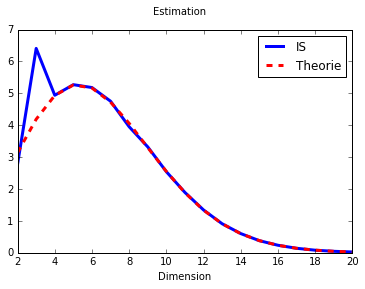

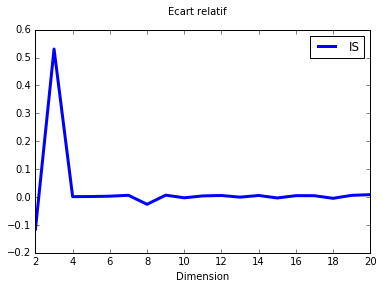

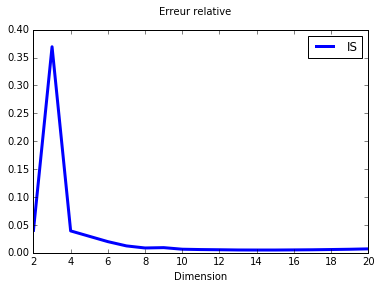

In [40]:
fig = plt.figure()
plt.plot(dimensions, est_IS[:,0], label="IS")
plt.plot(dimensions, val_th, 'r--', label="Theorie")
plt.legend()
plt.xlabel("Dimension")
fig.suptitle("Estimation")

fig = plt.figure()
plt.plot(dimensions, est_IS[:,1], label="IS")
plt.legend()
plt.xlabel("Dimension")
fig.suptitle("Ecart relatif")

fig = plt.figure()
plt.plot(dimensions, est_IS[:,2], label="IS")
plt.legend()
plt.xlabel("Dimension")
fig.suptitle("Erreur relative")

<p class="bg-primary" style="padding:1em">**QUESTION IV.2.6.** On cherche maintenant à comprendre l'influence de $\theta$. On fixe $N = 10^5$ et $d = 30$: tracez l'évolution de $\widehat V^{\text{IS}(\theta)}_d$, de l'écart relatif et de l'erreur relative correspondant pour $\theta \in [1,30]$ et discutez les résultats.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.2.6.** 
On constate que l'erreur relative et l'écart relative chutent lorsque $\theta$ dépasse 5. Pour $10 < \theta < 20$, l'erreur relative est même inférieur à 2%, ce qu'était impensable pour l'estimateur naïf à 30 dimensions. Si on l'augmente encore, l'erreur relative commence à monter et la valeur estimée devient moins stable (avec beaucoup plus de fluctuations).
</div>

In [41]:
N = 10**5
d = 30
theta = np.arange(5,30,1)
est_IS = np.zeros([len(theta),3])
for i in range(len(theta)):
    est_IS[i,:] = estimation_IS(d, N, theta[i])
print 'Ready!'

Ready!


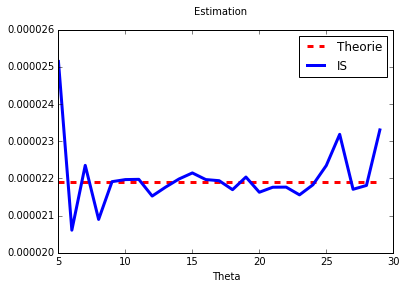

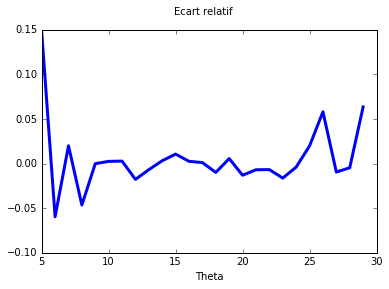

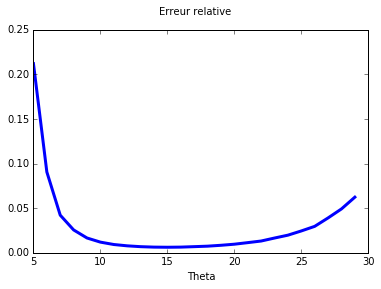

In [42]:
fig = plt.figure()
th = np.zeros([len(theta),1]) + np.pi**(d/2) / special.gamma(d/2+1)
plt.plot(theta, th, 'r--', label="Theorie")
plt.plot(theta, est_IS[:,0], label="IS")
plt.legend()
plt.xlabel("Theta")
fig.suptitle("Estimation")

fig = plt.figure()
plt.plot(theta, est_IS[:,1])
plt.xlabel("Theta")
fig.suptitle("Ecart relatif")

fig = plt.figure()
plt.plot(theta, est_IS[:,2])
plt.xlabel("Theta")
fig.suptitle("Erreur relative")

<p class="bg-primary" style="padding:1em">**QUESTION IV.2.7.** Pour $N = 10^5$ et $d = 30$, déterminez numériquement le paramètre $\theta_{\text{opt}}$ qui minimise l'erreur relative de $\widehat V_d^{\text{IS}(\theta)}$. Estimez l'erreur relative de $\widehat V_d^{\text{IS}(\theta_{\text{opt}})}$ et estimez le budget de simulation nécessaire pour déterminer $\theta_{\text{opt}}$. Evaluez le nombre d'échantillons nécessaires pour obtenir la même erreur relative que $\widehat V_d^{\text{IS}(\theta_{\text{opt}})}$ par IIDMC. Enfin, étudiez également l'influence de $N$ sur la procédure d'optimisation. </p>

<div class="alert alert-warning">**REPONSE A LA QUESTION IV.2.7.** 
Soit N la taille d'echantillon telle que IIMDC a la même erreur relative que IS. On sait que l'erreur relative de IIMDC varie selon $1/\sqrt{N}$, donc on peut calculer la taille necessaire comme ci-dessous:
$$ $$
$$\frac{\text{erreur relative}_{N=10^5}^{IIDMC}}{\text{erreur relative}_{IS}} = \frac{1/\sqrt{10^5}}{1/\sqrt{N}}$$
$$ $$
$$ N = 10^5\bigg(\frac{\text{erreur relative}_{N=10^5}^{IIDMC}}{\text{erreur relative}_{IS}}\bigg)^2$$
$$ $$
Les calculs numeriques montrent que c'est physiquement impossible de faire l'estimation avec IIDMC si l'on souhaite la même erreur relative. La taille de l'échantillon pour IIDMC est toujours de l'order de $10^{+18}$.
Pour $N=10^3$, $\theta = 14.8125$, avec un erreur relative de 0.00621. Pour $N=10^5$, $\theta = 14.8749$, avec un erreur relative de 0.006183. Toutefois, pour $N=10^7$, $\theta = 15.25$ mais l'erreur relative est de 0.006226. Le $\theta_{optimale}$ augmente lorsque $N$ augmente, mais l'erreur relative après $N^6$ n'a pas diminué.
</div>



In [43]:
from fonctions_estimation import estimation_IIDMC

def optim_var_IS(theta):
    vol_estim = estimation_IS(30, 10**5, theta)
    return vol_estim[2]

N = 10**5
d=30
x0 = 5
res_optim = minimize(optim_var_IS, x0, method='nelder-mead',options={'xtol': 1e-5, 'disp': True})
N_tot_IS = res_optim.nit*N
vol_estim = estimation_IS(30, 10**5, res_optim.x)
print '> Volume estime par echantillonnage preferentiel optimise:',vol_estim[0]
print '> avec un theta optimisé de',res_optim.x,'erreur relative de ',res_optim.fun,' pour un budget de simulations de',N_tot_IS+10**5
th = np.pi**(d/2) / special.gamma(d/2+1)
taille_MC = N*((estimation_IIDMC(d, N)[2])/(res_optim.fun))**2
print '> Nombre dechantillons Monte-Carlo necessaires pour obtenir une precision equivalente a IS:',taille_MC


Optimization terminated successfully.
         Current function value: 0.006219
         Iterations: 26
         Function evaluations: 65
> Volume estime par echantillonnage preferentiel optimise: 2.17334026834e-05
> avec un theta optimisé de [ 15.07824707] erreur relative de  0.00621915063533  pour un budget de simulations de 2700000
> Nombre dechantillons Monte-Carlo necessaires pour obtenir une precision equivalente a IS: 1.26674511587e+18






<a id="INTROMARKOV"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">V. Introduction aux chaînes de Markov</h1>

<h2> V.1. Vitesse(s) de convergence(s)</h2>

<p class="bg-primary" style="padding:1em">**QUESTION V.1.1.** Le script suivant génère une suite $(X_t)$ : quelles sont les valeurs prises par cette suite ? Expliquez simplement sa dynamique.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.1.** 
Le premier élément de la chaîne est $init$. L'élément $X_{k+1}$ va être égale à $X_{k}$ avec une probabilité de $p$, ou égale à $1-X_{k}$ avec une probabilité de $1-p$. Donc, chaque valeur suivante est calculée de forme aleatoire mais elle ne dépende que de la valeur actuelle. La suite va être une chaîne de Markov.
</div>



In [44]:
def Markov_intro(t_max, p, init):
    X = np.zeros(t_max)
    X[0] = init
    for time in range(1, t_max):
        if (np.random.random() < p):
            X[time] = X[time-1];
        else:
            X[time] = 1 - X[time-1];
    return X



<div class="alert alert-success" style="text-align: center;"> On dit qu'une suite $(Y_n)$ satisfait le **théorème ergodique** si la suite $(\bar Y_N)$ des moyennes empirique converge presque sûrement vers une constante, i.e., s'il existe une constante $\mu$ telle que $\displaystyle \bar Y_N = \frac{1}{N} \sum_{k=1}^N Y_k \stackrel{\text{p.s.}}{\to} \mu. $ </div>


<p class="bg-primary" style="padding:1em">**QUESTION V.1.2.** Une suite i.i.d. satisfait-elle le théorème ergodique ? Justifiez votre réponse.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.2.** 
Soit $Y_k$ une suite de variables aleatoires i.i.d., avec $\mu$ son ésperance et $\sigma^2$ sa variance. D'après le théorème central limite, on a:
$$ $$
$$ \lim_{N\to\infty} \frac{\sum_{k=1}^N Y_k - \mu}{\sqrt{\sigma^2/N}} \sim N(0, 1)$$
$$ $$
Donc,
$$ \lim_{N\to\infty} \sum_{k=1}^N Y_k \sim N\bigg(\mu, \frac{\sigma^2}{N}\bigg)$$
$$ $$
Pour N suffisamment grand, la variance s'approche de zero et donc la somme aleatoire va prend une valeur presque constante égale à $\mu$. Donc une suite de variables aleatoires i.i.d satisfait le théorème ergodique.
</div>



<p class="bg-primary" style="padding:1em">**QUESTION V.1.3.** Utilisez le script suivant pour vérifier que $(X_t)$ satisfait le théorème ergodique. Pour quelles valeurs de $p$ la convergence est-elle la plus rapide ? La condition initiale joue-t-elle un rôle ? Expliquez pourquoi.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.3.** 
$$ $$
La convergence est plus rapide pour $p$ inférieure. En effet, la courbe à bleu ($p=0.1$) est celle que converge plus vite, et la courbe violet ($p=0.9$) celle que converge plus lentement. La condition initiale ne change ceci, mais augmente le temps de convergence pour toutes les $p$ (parce que si l'on prend $init=1$ on va osciller entre 0 et 1, tandis que si l'on prend par exemple $init = 40$, on oscille entre 40 et -39, donc la moyenne prends plus longtemps pour stabiliser).
$$ $$
Pour l'influence de p: intuitivement, pour $p$ plus petite, il y'aura plus de chance que la valeur prochaine de la chaîne soit égale à la valeur actuelle et donc, la chaîne converge plus vite. Si $p$ tend vers 1, on change presque toujours d'état, donc elle prends plus longtemps pour stabiliser autour de la valeur constante.
</div>



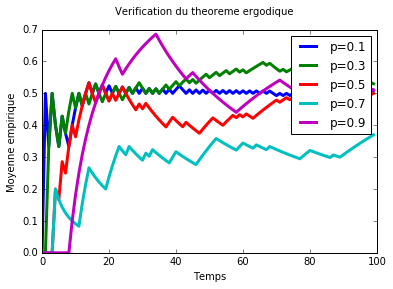

In [45]:
t_max = 10**2
val_p = np.arange(.1,1,.2)
nb_p = len(val_p)

fig, ax = plt.subplots()
for i in range(nb_p):
    p = val_p[i]
    traj = Markov_intro(t_max, p, 0)
    ax.plot(range(t_max), np.divide(np.cumsum(traj), range(1,1+len(traj))), label="p="+str(p))
plt.legend()
plt.suptitle("Verification du theoreme ergodique")
plt.xlabel("Temps")
plt.ylabel("Moyenne empirique")



<p class="bg-primary" style="padding:1em">**QUESTION V.1.4.** Pour quelle(s) valeur(s) de $p$ la suite $(X_t)$ est-elle i.i.d.? Concluez.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.4.** 
$$ $$
On considère comme hypothèse que $init = X_0 = x$, et que la suite $X_t$ est i.i.d.:
$$ $$
Pour $k>0$ et en utilisant le fait que $X_k$ et $X_{k-1}$ sont indépendants:
$$ $$
$$ P(X_k = x) = p(X_k = x \space\big\vert\space X_{k-1} = x) = p$$
$$ $$
$$ P(X_k = x) = p(X_k = x \space\big\vert\space X_{k-1} = 1-x) = 1-p$$
$$ $$
Pour vérifier l'égalité, on a besoin que:
$$ $$
$$ p = 1 - p $$
$$ $$
D'où sort que $p=0.5$. Pour cette valeur de p la suite sera donc i.i.d.

</div>




<div class="alert alert-success" style="text-align: center;"> On rappelle qu'une suite $(Y_n)$ de variables aléatoires à valeurs entières converge en loi vers une variable aléatoire $Y_\infty$, ce que l'on note $Y_n \stackrel{\text{d}}{\to} Y_\infty$, si $P(Y_n = k) \to P(Y_\infty = k)$ pour tout $k \in N$. </div>





<p class="bg-primary" style="padding:1em">**QUESTION V.1.5.** Proposez une méthode numérique pour vérifier que $X_n \stackrel{\text{L}}{\to} X_\infty$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.5.** 
$$ $$
Soit $Y_n$ notre suite (chaîne de Markov). Si l'on génére plusieures chaînes ($N$ chaînes), on peut calculer empiriquement $P(Y_n = k)$. Pour faire cela, je vais considérer $Y_n^i$ le n'ième élement de la i-ième chaîne. 
$$ $$
$$ P(Y_n = k) = \frac{1}{N}\sum_{i=1}^N\mathbb{1}(Y_n^i = 1)$$
$$ $$
Il faut maintenant faire ce calcul pour chaque élement de la chaîne, et pour n élevé, les valeurs doivent converger.
</div>



<p class="bg-primary" style="padding:1em">**QUESTION V.1.6.** Complétez le script suivant pour vérifier numériquement que $X_n \stackrel{\text{L}}{\to} X_\infty$: quelle est la limite ? dépend-elle de $p$? Expliquez comment jouer sur la condition initiale pour que la chaîne de Markov démarre directement à l'équilibre.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.6.**
$$ $$
Cependent les différents $p$ utilisées pour générer les chaînes, les probabilités $P(Y_n = 1)$ convergent toutes vers 0.5 lorsque n s'approche de l'infini (pour une chaîne initialisée à 1). Pour $10^4$ chaînes chacune avec une longueur de 50 élements la convergence est bien visible. La limite ne depend donc de $p$ utilisé lors de la creation de la chaîne.
</div>



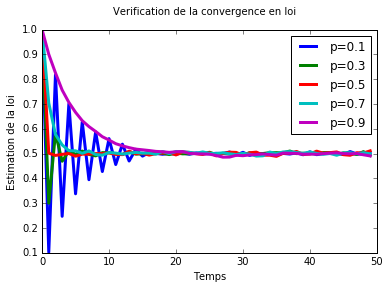

In [46]:
t_max = 5*10**1
taille_echantillon = 10**4
val_p = np.arange(.1,1,.2)
nb_p = len(val_p)

fig, ax = plt.subplots()
for i in range(nb_p):
    p = val_p[i]
    echantillon = np.zeros((taille_echantillon, t_max))
    for j in range(taille_echantillon):
        echantillon[j,:] = Markov_intro(t_max, p, 1) 
    estimation_loi = np.zeros(t_max)
    for t in range(t_max):
        estimation_loi[t] = (1.0/taille_echantillon)*np.sum(echantillon[:,t] == 1)       
    ax.plot(range(t_max), estimation_loi, label="p="+str(p))
plt.legend()
plt.suptitle("Verification de la convergence en loi")
plt.xlabel("Temps")
plt.ylabel("Estimation de la loi")


<p class="bg-primary" style="padding:1em">**QUESTION V.1.7.** Pour quelles valeurs de $p$ la convergence est-elle la plus rapide ? Comparez à la réponse de la question V.1.3 et commentez.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.7.** 
La convergence est maintenant plus rapide pour $p=0.5$, tandis qu'avant elle l'était pour $p=0.1$. On avait vu lors de l'étude du théorème ergodique que la moyenne de toutes les chaînes convergé vers 0.5, donc il était déjà attendu que la chaîne avec $p=0.5$ convergeait plus rapidement vers une variable aleatoire.
</div>


<p class="bg-primary" style="padding:1em">**QUESTION V.1.8.** Vérifiez numériquement que $\displaystyle \sqrt N \left( \bar X_N - \frac{1}{2} \right)$ suit approximativement une loi normale pour $N$ grand et faites le lien avec le théorème central limite</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION V.1.8.** 
Le resultat vient du théorème central limite et de la loi des grands nombres. Une fois que ici $\mu = 1/2$, donc la loi normal a une esperance nulle comme on constate d'après les résultats numériques.
</div>



In [55]:
t_max = 10**3
taille_echantillon = 10**4
p = .2
echantillon_markov = np.zeros((taille_echantillon, t_max))
echantillon = np.zeros(taille_echantillon)
x = np.zeros(taille_echantillon)
for j in range(taille_echantillon):
    echantillon_markov[j,:] = Markov_intro(t_max, p, 1) 
    echantillon[j] = (np.mean(echantillon_markov[j,:])-.5)*taille_echantillon**.5
print '> Ready!'

> Ready!


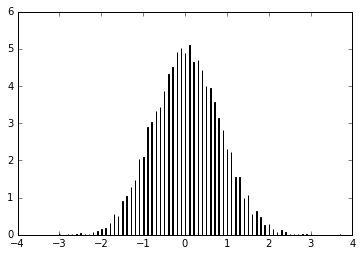

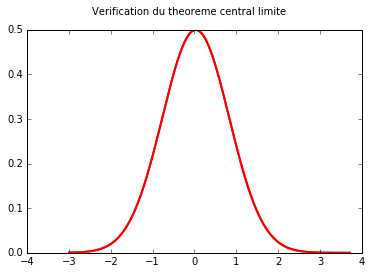

In [56]:
binwidth = 100.0/taille_echantillon
#count, bins, ignored = plt.hist(echantillon, normed=True)
count, bins, ignored = plt.hist(echantillon, normed=True, bins=np.arange(min(echantillon), max(echantillon) + binwidth, binwidth))
sigma = np.std(echantillon)
mu = np.mean(echantillon)
fig, ax = plt.subplots()
ax.plot(bins, 1.0/(sigma * np.sqrt(2.0 * np.pi)) * np.exp( - (bins - mu)**2.0 / (2.0 * sigma**2.0) ), linewidth=2, color='r')
ax.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma), linewidth=2, color='r')
plt.suptitle("Verification du theoreme central limite")

<br>

<br>

<br>

<br>

<br>


<br>

<br>

<br>

<br>

<br>





<a id="MCMC"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">VI. Méthodes de Monte-Carlo à base de chaînes de Markov</h1>






<div class="alert alert-success"> Si $(X_n)$ est une chaîne de Markov de mesure stationnaire $f$, alors le théorème ergodique pour les chaînes de Markov garantit que
$$ \displaystyle \widehat I^{\text{MCMC}} = \frac{1}{N} \sum_{k=1}^N \phi(X_k) $$
est un estimateur convergent de $\int \phi f$: on a remplacé un échantillon i.i.d. par la trajectoire d'un processus de Markov, on parle alors de méthode **MCMC** (par opposition à IIDMC). Cette méthode n'a d'intérêt que si l'on sait générer une chaîne de Markov avec une probabilité stationnaire donnée : l'**algorithme de Metropolis-Hastings** fait précisément cela, il s'agit de la pierre angulaire des méthodes MCMC.</div>



<h2> VI.1. Algorithme de Metropolis–Hastings</h2>

L'algorithme de Metropolis--Hastings est un algorithme général qui permet de générer une chaîne de Markov avec une distribution invariante donnée. Soit $\pi$ une mesure de probabilité sur un ensemble dénombrable $\mathfrak{X}$ et $K: \mathfrak{X} \times \mathfrak{X} \to [0,1]$ un noyau de transition, i.e., pour tout $x \in \mathfrak{X}$ la famille $K(x, \cdot) = (K(x,y), y \in \mathfrak{X})$ définit une mesure de probabilité sur $\mathfrak{X}$. L'algorithme de Metropolis-Hastings construit la chaîne de Markov suivante :
1. Tirer $Y_t$ selon la loi $K(X_t, \, \cdot)$;
2. Calculer
$$ \displaystyle \varrho(X_t, Y_t) = \min \left( 1, \frac{\pi(Y_t)}{\pi(X_t)} \frac{K(Y_t, X_t)}{K(X_t, Y_t)} \right); $$
3. Choisir $\displaystyle X_{t+1} = \begin{cases}
    Y_t & \text{ avec probabilité } \varrho(X_t, Y_t),\\
    X_t & \text{ avec probabilité } 1 - \varrho(X_t, Y_t).
\end{cases} $


<p class="bg-primary" style="padding:1em">**QUESTION VI.1.1.** Calculez $p_{xy} = P(X_2 = y \mid X_1 = x)$ puis montrez que $\pi_x p_{xy} = \pi_y p_{yx}$. Déduisez-en que $X$ admet $\pi$ comme probabilité stationnaire.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.1.1.**
$$ \displaystyle P(tirer \space y)P(accepter \space y \space | \space tirer \space y) = K(x,y)\rho(x,y)=K(x,y)min\bigg(1, \frac{\pi_y K(y,x)}{\pi_x K(x,y)}\bigg) = K(x,y)$$

$$P_{yx} = K(y,x)\frac{\pi_x K(x,y)}{\pi_y K(y,x)} = \frac{\pi_x}{\pi_y}K(x,y) = \frac{\pi_x}{\pi_y}p_{xy}$$
</div>





<p class="bg-primary" style="padding:1em">**QUESTION VI.1.2.** Décrivez simplement cet algorithme lorsque le noyau de transition ne dépend pas de l'état de départ, i.e., $K(x, \cdot \,) = k$ pour une certaine mesure de probabilité $k$, et tout $x \in \mathfrak{X}$. Faites le lien avec la méthode du rejet.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.1.2.** 
Dans se cas on fait:
$$ $$
1) Tirer $Y_t$ selon K;
$$ $$
2) Calculer de $\rho = min(1, \frac{\pi(Y_t)}{\pi(X_t)})$;
$$ $$
3) Tirer U selon $U_{[0,1]}$;
$$ $$
4) Accepter $Y_t$ si $U < \rho$. Sinon garder $X_t$.

Dans la méthode du rejet on accepté une valeur si $U \leq f(X)$, avec U uniformement repartie dans $[0,K], (K\geq 2sup(f))$ et où $f(X)$ était la densité que l'on souhaité simuler. Dans la méthode de Metropolis, on souhaite de générer une chaîne telle que les valeurs soient convergents vers une distribuition $\pi$. Si on suppose que $\frac{\pi(Y_t)}{\pi(X_t)}$ est inférieur à l'unité on peut reécrire le critère d'acceptation comme suit:
$$ $$
$$ U \leq \pi(Y_t), \text{ où } U \sim U[0, \pi(X_t)]$$
$$ $$
Cela ressemble à la méthode du rejet.
</div>



<p class="bg-primary" style="padding:1em">**QUESTION VI.1.3.** Décrivez simplement $Y_t$ lorsque le noyau de transition est de la forme $K(x, y) = k(y-x)$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.1.3.** </div>



<p class="bg-primary" style="padding:1em">**QUESTION VI.1.4.** Discutez des utilisations et avantages potentiels de l'algorithme de Metropolis-Hastings.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.1.4.** 
D'abord, cette méthode ne necessite que la connaissance de la distribuition $\pi$ à une constante près. Cela est très important une fois que la plupart du temps on ne connait les fonctions densités qu'à une constante près (car les constantes de normalization sont difficiles à calculer). En plus, cet algorithme lié à Monter-Carlo (MCMC) permet de resoudre de problèmes complexes en plusieurs dimensions où les autres méthodes échouent.
</div>




<div class="alert alert-success"> Dans le cas à densité, l'algorithme de Metropolis--Hastings est le même : un noyau de transition est une application $K: R^d \times R^d \to [0,1]$ telle que $K(x, \cdot \,)$ est une densité sur $R^d$ pour chaque $x \in R^d$, et $\pi$ est remplacée par une densité $f$ sur $R^d$. </div>




<h2> VI.2. Vitesse de convergence de la méthode MCMC</h2>


La méthode MCMC consiste donc à générer à l'aide de l'algorithme de Metropolis-Hastings une chaîne de Markov ayant une densité cible $f$ comme distribution stationnaire, puis de considérer l'estimateur
$$ \widehat I^{\text{MCMC}} = \frac{1}{N} \sum_{k=1}^N \phi(X_k) $$
qui est convergent par le théorème ergodique pour les chaînes de Markov.


<p class="bg-primary" style="padding:1em">**QUESTION VI.2.1.** A-t-on comme dans le cas IIDMC $\displaystyle \text{Var}(\widehat I^{\text{MCMC}}) = \frac{\text{Var}(\phi(X_1))}{\sqrt{N}}$? Pourquoi?</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.2.1.** 

$$ $$
$$Var[\widehat{I}^{MCMC}] = \frac{1}{N^2}Var\bigg[\sum_{k=1}^N\phi(X_k)\bigg] = 
\frac{1}{N^2}\sum_{k=1}^N Var\bigg[\phi(X_k)\bigg]$$
$$ $$
$$= \frac{1}{N}Var\big[\phi(X_1)\big] \space\text{   (si les variables } \space X_k\space \text{ sont i.i.d)}$$
$$ $$
Donc la formule n'est pas applicable si les variables aleatoires de la chaîne de Markov ne sont pas i.i.d.
</div>



<p class="bg-primary" style="padding:1em">**QUESTION VI.2.2.** Proposez une méthode numérique pour estimer $\text{Var}(\widehat I^{\text{MCMC}})$.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.2.2.** 
D'abord, générer N chaînes de Markov de taille M, ayant pour densité cible $f$, en utilisant l'algorithme de Metropolis-Hashtings. Puis générer N échantillons $\phi(x_k)$, où k varie de 0 à M. Comme cela, on peut estimer la variance de chaque élement des chaînes en utilisant numpy.var. Après on somme toutes les variances et on divise par le nombre de chaînes générées. Sauf si on sait d'abord que les variables aleatoires de la chaîne de Markov sont i.i.d. Dans ce cas, on pourrait utiliser le fait que la variance est égale à $\frac{\text{Var}(\phi(X_1))}{N}$
</div>



<h2> VI.3. Méthode MCMC pour l’estimation du volume de la sphère</h2>


On retourne à l'exemple de la sphère. On propose quatre noyaux de transition :
* **Noyau uniforme - indépendant:** $K(x, \cdot \,)$ est la mesure uniforme sur $[-1,1]^d$;
* **Noyau uniforme - marche aléatoire:** $K(x, y) \propto {\bf 1}(\lVert y - x \rVert \leq \delta)$;
* **Noyau beta - indépendant:** $K(x, \cdot \,) = g_\theta$ avec $g_\theta$ introduit dans le BE sur l'échantillonnage préférentiel;
* **Noyau gaussien - marche aléatoire:** $K(x, y) \propto \exp \left( -\lVert y - x \rVert^2 / (2 \sigma^2) \right)$.


<p class="bg-primary" style="padding:1em">**QUESTION VI.3.1.** Décrivez par écrit l'algorithme de Metropolis-Hastings dans chacun des ces cas.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.3.1.** 
$$ $$
On prend la dernière valeur de la chaîne ($X_t$) et après:
$$ $$
1) On tire Y selon K, où K est une des distribuitions mentionnées.
$$ $$
2) On calcule $K(X_t, Y)$, et $K(X_t, Y)$, en utilisant les fonction densité $K$ à une constante multiplicative près.
$$ $$
3) On calcule $\pi(X_t)$ et $\pi(Y)$. Dans notre cas, la distribuition stationnaire était uniforme, donc ces valeurs sont toujours égales à l'unité (car $X_t$ et $Y$ sont dedans $[-1, 1]^d$.
$$ $$
4) On calcule $\rho$ selon la formule specifiée
$$ $$
5) On tire U uniformement dans $[0,1]$.
$$ $$
6) On accepte le $Y$ comme le prochaine valeur de la chaîne si $U \leq \rho$. Sinon la prochaine valeur est la même que la valeur actuelle.
</div>



<p class="bg-primary" style="padding:1em">**QUESTION VI.3.2.** Complétez les fonctions ``estimation_MCMC_XXX`` qui implantent ces algorithmes. Pour vérifier votre code, vous vérifierez numériquement et en petite dimension que ces quatre chaînes de Markov ont bien comme distribution stationnaire la mesure uniforme sur la sphère.</p>

<div class="alert alert-warning">**REPONSE A LA QUESTION VI.3.2.** 
J'ai généré des châines de Markov avec plusieurs noyaux et avec la distribuition uniforme comme distribuition stationnaire des chaînes. Après j'ai utilisé la méthode de Monte Carlo avec elles pour estimer le volume d'une sphère.
</div>



In [57]:
def markov_chain(chain_size, noyau, dim):
    x = np.zeros((chain_size, dim))
    y = np.zeros((chain_size, dim))
    x[0,:] = 0.0   
    for i in range (chain_size-1):
        if noyau == "uniform_ind":
            y = np.random.uniform(-1, 1, size=dim)
            K_num = 1
            K_den = 1
            pi_num = 1
            pi_den = 1
        elif noyau == "uniform_ma":
            y = np.random.uniform(-1, 1, size=dim)
            if (np.linalg.norm(y - x[i,:]) <= 2**dim):
                K_num = 1.0
            else:
                K_num = 0
            if (np.linalg.norm(x[i,:]-y) <= 2**dim):
                K_den = 1
            else:
                K_den = 0
            pi_num = 1
            pi_den = 1
        elif noyau == "gaussien":
            y = np.random.normal(0, 1, size=dim)
            K_num = np.exp(-((np.linalg.norm((y-x[i,:]), 2)**2)/2))
            K_den = np.exp(-((np.linalg.norm((-y+x[i,:]),2)**2)/2))
            pi_num = 1
            pi_den = 1            
        num = pi_num*K_num
        den = pi_den*K_den
        accept_probability = np.minimum(1, num/den)    
        if (np.random.uniform(0, 1) <= accept_probability):
            x[i+1,:] = y
        else:
            x[i+1,:] = x[i+1,:]           
    return x

def estimation_MCMC_unif_ind():
    sample = markov_chain(10**4, "uniform_ind", 2)
    dim = np.size(sample, 1)
    N = np.size(sample, 0)
    estimation = ((2.0**dim) / N) * np.sum(np.linalg.norm(sample,2,axis=1) <= 1.0)
    return estimation
    
def estimation_MCMC_unif_MA():
    sample = markov_chain(10**4, "uniform_ma", 2)
    dim = np.size(sample, 1)
    N = np.size(sample, 0)
    estimation = ((2.0**dim) / N) * np.sum(np.linalg.norm(sample,2,axis=1) <= 1.0)
    return estimation

def estimation_MCMC_gaussien():
    sample = markov_chain(10**4, "gaussien", 2)
    dim = np.size(sample, 1)
    N = np.size(sample, 0)
    estimation = ((2.0**dim) / N) * np.sum(np.linalg.norm(sample,2,axis=1) <= 1.0)
    return estimation  

#def estimation_MCMC_beta():

In [59]:
print 'Volume (uniforme ind): ', estimation_MCMC_unif_ind()
print 'Volume (uniforme): ', estimation_MCMC_unif_MA()
print 'Volume (gaussien): ', estimation_MCMC_gaussien()

Volume (uniforme ind):  3.1308
Volume (uniforme):  3.1616
Volume (gaussien):  1.586
